### 0. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tqdm
!apt-get install -y abcmidi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  abcm2ps timidity | pmidi postscript-viewer
The following NEW packages will be installed:
  abcmidi
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 306 kB of archives.
After this operation, 868 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 abcmidi amd64 20220218+ds1-1 [306 kB]
Fetched 306 kB in 2s (204 kB/s)
Selecting previously unselected package abcmidi.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../abcmidi_20220218+ds1-1_amd64.deb ...
Unpacking abcmidi (20220218+ds1-1) ...
Setting up abcmidi (20220218+ds1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [3]:
import os
import subprocess
import glob
import pickle
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm  # Use notebook version for Colab
import zipfile
import shutil
import gzip
from collections import Counter
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import time
from dataclasses import dataclass
from typing import Optional, List, Dict
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from torch.utils.data import Dataset, DataLoader
import tempfile

### 1. Data Collection and Preprocessing

#### 1.1 Convert Data to ABC Notation

In [ ]:
def convert_single_file(args):
    midi_path, source_folder, output_folder = args

    relative_path = os.path.relpath(os.path.dirname(midi_path), source_folder)
    output_dir = os.path.join(output_folder, relative_path)
    os.makedirs(output_dir, exist_ok=True)

    abc_filename = os.path.splitext(os.path.basename(midi_path))[0] + '.abc'
    abc_path = os.path.join(output_dir, abc_filename)

    try:
        subprocess.run(
            ['midi2abc', midi_path, '-o', abc_path],
            check=True,
            capture_output=True,
            timeout=10
        )
        return True
    except:
        return False

In [ ]:
def convert_all_parallel(source_folder, output_folder=None, num_workers=None):
    if output_folder is None:
        output_folder = source_folder + "_abc"

    if num_workers is None:
        num_workers = cpu_count()

    midi_files = glob.glob(os.path.join(source_folder, "**/*.mid"), recursive=True)
    midi_files += glob.glob(os.path.join(source_folder, "**/*.midi"), recursive=True)

    print(f"Found {len(midi_files)} MIDI files")
    print(f"Using {num_workers} workers")

    args = [(f, source_folder, output_folder) for f in midi_files]

    # Use imap_unordered for better progress tracking
    converted = 0
    failed = 0

    with Pool(num_workers) as pool:
        for result in tqdm(pool.imap_unordered(convert_single_file, args),
                          total=len(midi_files),
                          desc="Converting"):
            if result:
                converted += 1
            else:
                failed += 1

    print(f"\nConverted: {converted}, Failed: {failed}")

In [ ]:
DIR = "/content/drive/MyDrive/CS-GY 6923/Project"

# Define paths
zip_path = DIR + "/lmd_full.zip"
unzipped_source_folder = "/content/lmd_full"

# Unzip using Python's zipfile
if os.path.exists(zip_path) and not os.path.exists(unzipped_source_folder):
    print(f"Unzipping {zip_path}...")
    os.makedirs(unzipped_source_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzipped_source_folder)
    print("Unzipping complete.")

    # Clean up nested folder structure from Mac zip
    if os.path.exists("/content/lmd_full/lmd_full"):
        print("Cleaning up folder structure...")

        # Remove __MACOSX junk if it exists
        if os.path.exists("/content/lmd_full/__MACOSX"):
            shutil.rmtree("/content/lmd_full/__MACOSX")

        # Move contents up one level
        shutil.move("/content/lmd_full/lmd_full", "/content/lmd_full_actual")

        # Remove the now-empty old folder
        shutil.rmtree("/content/lmd_full")

        # Rename to original expected name
        shutil.move("/content/lmd_full_actual", "/content/lmd_full")

        print("Cleaned up folder structure!")

elif os.path.exists(unzipped_source_folder):
    print(f"'{unzipped_source_folder}' already exists. Skipping unzip.")
else:
    print(f"Warning: '{zip_path}' not found.")

# Set the source
source = unzipped_source_folder

# Verify MIDI files exist
midi_files = glob.glob(os.path.join(source, "**/*.mid"), recursive=True)
print(f"Found {len(midi_files):,} MIDI files")

# Output folder for converted ABC files
output_local_folder = "/content/lmd_full_abc"
os.makedirs(output_local_folder, exist_ok=True)

# Convert all MIDI files to ABC notation
print(f"\nStarting conversion of MIDI to ABC. Output will be saved locally to: {output_local_folder}")
convert_all_parallel(source, output_local_folder)
print("Conversion complete.")

# Create zip archive and save to Google Drive
abc_zip_path_gdrive = os.path.join(DIR, "lmd_full_abc.zip")
print(f"\nCreating zip archive and saving to: {abc_zip_path_gdrive}")
shutil.make_archive(base_name=os.path.join(DIR, "lmd_full_abc"), format='zip', root_dir=output_local_folder)
print("ABC files zipped successfully to Google Drive!")

Unzipping /content/drive/MyDrive/CS-GY 6923/Project/lmd_full.zip...
Unzipping complete.
Cleaning up folder structure...
Cleaned up folder structure!
Found 178,561 MIDI files

Starting conversion of MIDI to ABC. Output will be saved locally to: /content/abc_converted_local
Found 178561 MIDI files
Using 2 workers


Converting:   0%|          | 0/178561 [00:00<?, ?it/s]


Converted: 174509, Failed: 4052
Conversion complete.

Creating zip archive and saving to: /content/drive/MyDrive/CS-GY 6923/Project/abc_converted.zip
ABC files zipped successfully to Google Drive!


#### 1.2 Design a Tokenization Scheme

In [ ]:
# Copy the data to local storage to make the tokenization faster by avoiding I/O with Google Drive
# !cp -r "/content/drive/MyDrive/CS-GY 6923/Project/abc" "/content/lmd_full_abc"

In [ ]:
# 1. Find all ABC files
abc_files = glob.glob("/content/lmd_full_abc/**/*.abc", recursive=True)
print(f"Found {len(abc_files):,} files")

# 2. Build vocabulary by scanning files (don't store content)
print("\nBuilding vocabulary...")
chars = set()
for path in tqdm(abc_files, desc="Scanning"):
    with open(path, 'r', errors='ignore') as f:
        chars.update(f.read())

chars = sorted(list(chars))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# 3. Create encode/decode functions
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

# 4. Print results
print(f"\nVocabulary size: {vocab_size}")
print(f"Characters: {''.join(chars)}")

# 5. Save to Google Drive
meta = {
    'vocab_size': vocab_size,
    'stoi': stoi,
    'itos': itos,
    'chars': chars,
}
with open('/content/drive/MyDrive/CS-GY 6923/Project/meta.pkl', 'wb') as f:
    pickle.dump(meta, f)

# Save the list of abc_files paths (which now point to the local storage)
with open('/content/drive/MyDrive/CS-GY 6923/Project/abc_files.pkl', 'wb') as f:
    pickle.dump(abc_files, f)

print("\nSaved meta.pkl and abc_files.pkl to Google Drive!")


Found 178,561 files

Building vocabulary...


Scanning:   0%|          | 0/178561 [00:00<?, ?it/s]


Vocabulary size: 100
Characters: 	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~

Saved meta.pkl and abc_files.pkl to Google Drive!


#### 1.3 Create Train/Validation/Test Splits (98%/1%/1%)

In [ ]:
# 1. Calculate total size
print("Calculating total size...")
total_size = 0
for path in tqdm(abc_files, desc="Counting"):
    total_size += os.path.getsize(path) + 2
print(f"Estimated total characters: {total_size:,}")

# 2. Calculate split points
train_end = int(0.98 * total_size)
val_end = int(0.99 * total_size)

# 3. Write in batches (one file at a time, not one character)
print("\nEncoding and writing splits...")

train_file = open('train.bin', 'wb')
val_file = open('val.bin', 'wb')
test_file = open('test.bin', 'wb')

current_pos = 0
train_count = 0
val_count = 0
test_count = 0

for path in tqdm(abc_files, desc="Encoding"):
    with open(path, 'r', errors='ignore') as f:
        text = f.read() + "\n\n"

    # Encode entire file at once
    tokens = np.array([stoi[ch] for ch in text if ch in stoi], dtype=np.uint16)
    n_tokens = len(tokens)

    # Figure out where this file's tokens go
    file_end = current_pos + n_tokens

    if file_end <= train_end:
        train_file.write(tokens.tobytes())
        train_count += n_tokens
    elif current_pos >= val_end:
        test_file.write(tokens.tobytes())
        test_count += n_tokens
    elif current_pos >= train_end:
        val_part = min(n_tokens, val_end - current_pos)
        if val_part > 0:
            val_file.write(tokens[:val_part].tobytes())
            val_count += val_part
        if val_part < n_tokens:
            test_file.write(tokens[val_part:].tobytes())
            test_count += n_tokens - val_part
    else:
        train_part = train_end - current_pos
        train_file.write(tokens[:train_part].tobytes())
        train_count += train_part

        remaining = tokens[train_part:]
        val_part = min(len(remaining), val_end - train_end)
        if val_part > 0:
            val_file.write(remaining[:val_part].tobytes())
            val_count += val_part
        if val_part < len(remaining):
            test_file.write(remaining[val_part:].tobytes())
            test_count += len(remaining) - val_part

    current_pos = file_end

train_file.close()
val_file.close()
test_file.close()

# 4. Print stats
print(f"\n{'='*50}")
print(f"DATASET STATISTICS")
print(f"{'='*50}")
print(f"Total tokens: {current_pos:,}")
print(f"Train: {train_count:,} tokens ({train_count/current_pos*100:.1f}%)")
print(f"Val: {val_count:,} tokens ({val_count/current_pos*100:.1f}%)")
print(f"Test: {test_count:,} tokens ({test_count/current_pos*100:.1f}%)")
print(f"Vocabulary size: {vocab_size}")
print(f"{'='*50}")

Calculating total size...


Counting:   0%|          | 0/178561 [00:00<?, ?it/s]

Estimated total characters: 13,871,805,664

Encoding and writing splits...


Encoding:   0%|          | 0/178561 [00:00<?, ?it/s]


DATASET STATISTICS
Total tokens: 13,871,805,664
Train: 13,594,369,550 tokens (98.0%)
Val: 138,718,057 tokens (1.0%)
Test: 138,718,057 tokens (1.0%)
Vocabulary size: 100

Compressing and saving to Google Drive...


NameError: name 'gzip' is not defined

In [ ]:
# 5. Compress and save to Google Drive
print("\nCompressing and saving to Google Drive...")

for filename in ['train.bin', 'val.bin', 'test.bin']:
    local_path = filename
    gz_path = f'/content/drive/MyDrive/CS-GY 6923/Project/{filename}.gz'

    with open(local_path, 'rb') as f_in:
        with gzip.open(gz_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Show compression ratio
    original_size = os.path.getsize(local_path)
    compressed_size = os.path.getsize(gz_path)
    ratio = compressed_size / original_size * 100
    print(f"{filename}: {original_size/1e9:.2f} GB → {compressed_size/1e9:.2f} GB ({ratio:.1f}%)")

print("\nSaved train.bin.gz, val.bin.gz, test.bin.gz to Google Drive!")


Compressing and saving to Google Drive...
train.bin: 27.19 GB → 0.64 GB (2.4%)
val.bin: 0.28 GB → 0.00 GB (0.3%)
test.bin: 0.28 GB → 0.01 GB (2.8%)

Saved train.bin.gz, val.bin.gz, test.bin.gz to Google Drive!


#### 1.3.1 Save/Load Checkpoint (Skip the tokenization and train/val/test set separation)

In [25]:
DIR = "/content/drive/MyDrive/CS-GY 6923/Project"
ABC_EXTRACT_DIR = "/content/lmd_full_abc"  # Local storage for faster access

print("=" * 50)
print("RESTORING SESSION FROM CHECKPOINT")
print("=" * 50)

# 1. Load metadata (vocabulary)
meta_path = os.path.join(DIR, "meta.pkl")
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)

    vocab_size = meta['vocab_size']
    stoi = meta['stoi']
    itos = meta['itos']
    chars = meta['chars']

    encode = lambda s: [stoi[c] for c in s if c in stoi]
    decode = lambda l: ''.join([itos[i] for i in l])

    print(f"✓ Loaded vocabulary: {vocab_size} characters")
else:
    print(f"✗ meta.pkl not found at {meta_path}")

# 2. Extract and load ABC files
ABC_ZIP = os.path.join(DIR, "lmd_full_abc.zip")

if os.path.exists(ABC_ZIP):
    # Check if already extracted
    if os.path.exists(ABC_EXTRACT_DIR) and len(os.listdir(ABC_EXTRACT_DIR)) > 0:
        print(f"✓ ABC files already extracted")
    else:
        print(f"  Extracting ABC files from zip...")
        os.makedirs(ABC_EXTRACT_DIR, exist_ok=True)
        with zipfile.ZipFile(ABC_ZIP, 'r') as z:
            z.extractall(ABC_EXTRACT_DIR)
        print(f"✓ Extracted ABC files")

    # Build file list from extracted files
    abc_files = []
    for root, dirs, files in os.walk(ABC_EXTRACT_DIR):
        for f in files:
            if f.endswith('.abc'):
                abc_files.append(os.path.join(root, f))

    print(f"✓ Found {len(abc_files):,} ABC files")
else:
    # Fallback to saved file list (won't work if paths are stale)
    files_path = os.path.join(DIR, "abc_files.pkl")
    if os.path.exists(files_path):
        with open(files_path, 'rb') as f:
            abc_files = pickle.load(f)
        print(f"⚠ Loaded file list from pickle: {len(abc_files):,} (paths may be stale)")
    else:
        print(f"✗ No ABC files found")
        abc_files = []

# 3. Memory-efficient loading function
def load_compressed_bin(gz_path, name="data"):
    """Load gzipped binary file without doubling memory usage"""
    print(f"  Loading {os.path.basename(gz_path)}...")

    # Decompress to temp file first
    with tempfile.NamedTemporaryFile(delete=False, suffix='.bin') as tmp:
        tmp_path = tmp.name

    print(f"    Decompressing...", end=" ", flush=True)
    with gzip.open(gz_path, 'rb') as f_in:
        with open(tmp_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("done")

    # Memory-map the file (doesn't load into RAM until accessed)
    print(f"    Memory-mapping...", end=" ", flush=True)
    data = np.memmap(tmp_path, dtype=np.uint16, mode='r')
    print("done")

    return data, tmp_path

# 4. Load datasets
temp_files = []  # Track temp files for cleanup

train_path = os.path.join(DIR, "train.bin.gz")
if os.path.exists(train_path):
    train_data, tmp = load_compressed_bin(train_path, "train")
    temp_files.append(tmp)
    print(f"✓ Loaded train data: {len(train_data):,} tokens")

val_path = os.path.join(DIR, "val.bin.gz")
if os.path.exists(val_path):
    val_data, tmp = load_compressed_bin(val_path, "val")
    temp_files.append(tmp)
    print(f"✓ Loaded val data: {len(val_data):,} tokens")

test_path = os.path.join(DIR, "test.bin.gz")
if os.path.exists(test_path):
    test_data, tmp = load_compressed_bin(test_path, "test")
    temp_files.append(tmp)
    print(f"✓ Loaded test data: {len(test_data):,} tokens")

# 5. Summary
print("\n" + "=" * 50)
print("SESSION RESTORED")
print("=" * 50)
print(f"  vocab_size: {vocab_size}")
print(f"  abc_files: {len(abc_files):,} files")
print(f"  train_data: {len(train_data):,} tokens")
print(f"  val_data: {len(val_data):,} tokens")
print(f"  test_data: {len(test_data):,} tokens")
print("=" * 50)

# 6. Quick sanity checks
print("\nSample from training data (first 200 chars):")
print("-" * 50)
print(decode(train_data[:200].tolist()))
print("-" * 50)

# Verify ABC files are readable
if abc_files:
    print("\nSample ABC file:")
    print("-" * 50)
    with open(abc_files[0], 'r', errors='ignore') as f:
        print(f.read()[:300])
    print("-" * 50)

RESTORING SESSION FROM CHECKPOINT
✓ Loaded vocabulary: 100 characters
  Extracting ABC files from zip...
✓ Extracted ABC files
✓ Found 178,561 ABC files
  Loading train.bin.gz...
    Decompressing... done
    Memory-mapping... done
✓ Loaded train data: 13,594,369,550 tokens
  Loading val.bin.gz...
    Decompressing... done
    Memory-mapping... done
✓ Loaded val data: 138,718,057 tokens
  Loading test.bin.gz...
    Decompressing... done
    Memory-mapping... done
✓ Loaded test data: 138,718,057 tokens

SESSION RESTORED
  vocab_size: 100
  abc_files: 178,561 files
  train_data: 13,594,369,550 tokens
  val_data: 138,718,057 tokens
  test_data: 138,718,057 tokens

Sample from training data (first 200 chars):
--------------------------------------------------
X: 1
T: from /content/lmd_full/0/0e8e143cc52958bfcf23f0815ad6ab22.mid
M: 4/4
L: 1/8
Q:1/4=127
K:G % 1 sharps
V:1
%%clef bass
%%MIDI program 30
[G-D-G,-]6 [GDG,][A-D-G,-D,-]| \
[ADG,D,][GD] GD GF DD,-|
---------------------------------

#### 1.4 Data Cleaning

#### 1.4.1 Analyze File Statistics

In [ ]:
print("\n1. Analyzing ABC files...")

file_stats = []
invalid_files = []
empty_files = []

for path in tqdm(abc_files, desc="Scanning files"):
    try:
        with open(path, 'r', errors='ignore') as f:
            content = f.read()

        if len(content.strip()) == 0:
            empty_files.append(path)
            continue

        # Check for basic ABC structure
        has_header = any(content.startswith(x) for x in ['X:', 'T:', 'M:', 'K:'])
        has_notes = any(c in content for c in 'ABCDEFGabcdefg')

        if not has_header or not has_notes:
            invalid_files.append((path, "Missing header or notes"))
            continue

        tokens = len([ch for ch in content if ch in stoi])
        file_stats.append({
            'path': path,
            'chars': len(content),
            'tokens': tokens,
            'lines': content.count('\n')
        })

    except Exception as e:
        invalid_files.append((path, str(e)))

print(f"\n✓ Valid files: {len(file_stats):,}")
print(f"✗ Empty files: {len(empty_files):,}")
print(f"✗ Invalid files: {len(invalid_files):,}")

print("\n2. Token length distribution:")

token_counts = [f['tokens'] for f in file_stats]

percentiles = [0, 1, 5, 25, 50, 75, 95, 99, 100]
for p in percentiles:
    val = np.percentile(token_counts, p)
    print(f"  {p:3d}th percentile: {val:,.0f} tokens")

print(f"\n  Mean: {np.mean(token_counts):,.0f} tokens")
print(f"  Std:  {np.std(token_counts):,.0f} tokens")


1. Analyzing ABC files...


Scanning files:   0%|          | 0/178561 [00:00<?, ?it/s]


✓ Valid files: 175,961
✗ Empty files: 2,600
✗ Invalid files: 0

2. Token length distribution:
    0th percentile: 120 tokens
    1th percentile: 232 tokens
    5th percentile: 791 tokens
   25th percentile: 7,426 tokens
   50th percentile: 19,363 tokens
   75th percentile: 31,295 tokens
   95th percentile: 54,596 tokens
   99th percentile: 87,370 tokens
  100th percentile: 549,109,888 tokens

  Mean: 78,833 tokens
  Std:  3,336,546 tokens


#### 1.4.2 Define Filtering Criteria

In [ ]:
# Adjust these thresholds based on the distribution above
MIN_TOKENS = 200      # Filter out very short sequences (likely incomplete)
MAX_TOKENS = 100000   # Filter out extremely long sequences (outliers)

print(f"\n3. Filtering criteria:")
print(f"  MIN_TOKENS: {MIN_TOKENS}")
print(f"  MAX_TOKENS: {MAX_TOKENS}")

print("\n4. Applying filters...")

filtered_stats = [
    f for f in file_stats
    if MIN_TOKENS <= f['tokens'] <= MAX_TOKENS
]

too_short = [f for f in file_stats if f['tokens'] < MIN_TOKENS]
too_long = [f for f in file_stats if f['tokens'] > MAX_TOKENS]

print(f"\n  Original valid files: {len(file_stats):,}")
print(f"  Too short (<{MIN_TOKENS}): {len(too_short):,}")
print(f"  Too long (>{MAX_TOKENS}): {len(too_long):,}")
print(f"  ✓ After filtering: {len(filtered_stats):,}")


3. Filtering criteria:
  MIN_TOKENS: 200
  MAX_TOKENS: 100000

4. Applying filters...

  Original valid files: 175,961
  Too short (<200): 1,083
  Too long (>100000): 1,226
  ✓ After filtering: 173,652


#### 1.4.3 Create Cleaned Files

In [ ]:
abc_files_cleaned = [f['path'] for f in filtered_stats]

print(f"\n5. Cleaned dataset:")
print(f"  Files: {len(abc_files_cleaned):,}")
print(f"  Total tokens: {sum(f['tokens'] for f in filtered_stats):,}")


5. Cleaned dataset:
  Files: 173,652
  Total tokens: 3,737,314,329


#### 1.4.4 Document Filtering Criteria

In [ ]:
report = {
    'total_original': len(abc_files),
    'empty_files': len(empty_files),
    'invalid_files': len(invalid_files),
    'too_short': len(too_short),
    'too_long': len(too_long),
    'final_count': len(abc_files_cleaned),
    'min_tokens': MIN_TOKENS,
    'max_tokens': MAX_TOKENS,
    'token_percentiles': {p: np.percentile(token_counts, p) for p in percentiles}
}

# Save report
report_path = os.path.join(DIR, "cleaning_report.pkl")
with open(report_path, 'wb') as f:
    pickle.dump(report, f)

# Save cleaned file list
cleaned_files_path = os.path.join(DIR, "abc_files_cleaned.pkl")
with open(cleaned_files_path, 'wb') as f:
    pickle.dump(abc_files_cleaned, f)

print(f"\n✓ Saved cleaning_report.pkl")
print(f"✓ Saved abc_files_cleaned.pkl")

print("\n" + "=" * 50)
print("CLEANING SUMMARY")
print("=" * 50)
print(f"  Original files:     {len(abc_files):,}")
print(f"  - Empty:            {len(empty_files):,}")
print(f"  - Invalid:          {len(invalid_files):,}")
print(f"  - Too short:        {len(too_short):,}")
print(f"  - Too long:         {len(too_long):,}")
print(f"  ────────────────────────────")
print(f"  Final cleaned:      {len(abc_files_cleaned):,} ({len(abc_files_cleaned)/len(abc_files)*100:.1f}%)")
print("=" * 50)

print("\n6. Examples of filtered files:")

if too_short:
    print(f"\n  Too short (showing first 3):")
    for f in too_short[:3]:
        print(f"    {os.path.basename(f['path'])}: {f['tokens']} tokens")

if too_long:
    print(f"\n  Too long (showing first 3):")
    for f in too_long[:3]:
        print(f"    {os.path.basename(f['path'])}: {f['tokens']} tokens")

if invalid_files:
    print(f"\n  Invalid (showing first 3):")
    for path, reason in invalid_files[:3]:
        print(f"    {os.path.basename(path)}: {reason}")


✓ Saved cleaning_report.pkl
✓ Saved abc_files_cleaned.pkl

CLEANING SUMMARY
  Original files:     178,561
  - Empty:            2,600
  - Invalid:          0
  - Too short:        1,083
  - Too long:         1,226
  ────────────────────────────
  Final cleaned:      173,652 (97.3%)

6. Examples of filtered files:

  Too short (showing first 3):
    0d33bc6bed4199593f6a1d371395c4c3.abc: 161 tokens
    00528212887c64888bb17a8e470fee67.abc: 159 tokens
    0fa65ab13ba728d2db73a0d354d35ebd.abc: 187 tokens

  Too long (showing first 3):
    0b59d884feb0ac668a42cd5e749e5b8f.abc: 123355 tokens
    049eb6ecb7adeee42fb6fca74ac5ee12.abc: 105444 tokens
    05633f64567fae173028abdc170ed7ad.abc: 108987 tokens


### 2. Transformer Scaling Study

#### 2.0 Checkpoint

In [ ]:
DIR = "/content/drive/MyDrive/CS-GY 6923/Project"
ABC_EXTRACT_DIR = "/content/lmd_full_abc"

print("=" * 50)
print("RESTORING SESSION FROM CHECKPOINT")
print("=" * 50)

# 1. Load metadata (vocabulary)
meta_path = os.path.join(DIR, "meta.pkl")
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)

    vocab_size = meta['vocab_size']
    stoi = meta['stoi']
    itos = meta['itos']
    chars = meta['chars']

    encode = lambda s: [stoi[c] for c in s if c in stoi]
    decode = lambda l: ''.join([itos[i] for i in l])

    print(f"✓ Loaded vocabulary: {vocab_size} characters")
else:
    print(f"✗ meta.pkl not found at {meta_path}")

# 2. Load CLEANED file list (not the original abc_files.pkl)
cleaned_files_path = os.path.join(DIR, "abc_files_cleaned.pkl")
if os.path.exists(cleaned_files_path):
    with open(cleaned_files_path, 'rb') as f:
        abc_files_cleaned = pickle.load(f)
    print(f"✓ Loaded cleaned file list: {len(abc_files_cleaned):,} files")
else:
    print(f"✗ abc_files_cleaned.pkl not found")
    abc_files_cleaned = []

# 3. Load cleaning report for reference
report_path = os.path.join(DIR, "cleaning_report.pkl")
if os.path.exists(report_path):
    with open(report_path, 'rb') as f:
        cleaning_report = pickle.load(f)
    print(f"✓ Loaded cleaning report")
else:
    cleaning_report = None

# 4. Extract ABC files if needed (for generation/validation later)
ABC_ZIP = os.path.join(DIR, "lmd_full_abc.zip")
if os.path.exists(ABC_ZIP):
    if os.path.exists(ABC_EXTRACT_DIR) and len(os.listdir(ABC_EXTRACT_DIR)) > 0:
        print(f"✓ ABC files already extracted")
    else:
        print(f"  Extracting ABC files from zip...")
        os.makedirs(ABC_EXTRACT_DIR, exist_ok=True)
        with zipfile.ZipFile(ABC_ZIP, 'r') as z:
            z.extractall(ABC_EXTRACT_DIR)
        print(f"✓ Extracted ABC files")

# 5. Memory-efficient loading function
def load_compressed_bin(gz_path, name="data"):
    """Load gzipped binary file without doubling memory usage"""
    print(f"  Loading {os.path.basename(gz_path)}...")

    with tempfile.NamedTemporaryFile(delete=False, suffix='.bin') as tmp:
        tmp_path = tmp.name

    print(f"    Decompressing...", end=" ", flush=True)
    with gzip.open(gz_path, 'rb') as f_in:
        with open(tmp_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("done")

    print(f"    Memory-mapping...", end=" ", flush=True)
    data = np.memmap(tmp_path, dtype=np.uint16, mode='r')
    print("done")

    return data, tmp_path

# 6. Load datasets
temp_files = []

train_path = os.path.join(DIR, "train.bin.gz")
if os.path.exists(train_path):
    train_data, tmp = load_compressed_bin(train_path, "train")
    temp_files.append(tmp)
    print(f"✓ Loaded train data: {len(train_data):,} tokens")

val_path = os.path.join(DIR, "val.bin.gz")
if os.path.exists(val_path):
    val_data, tmp = load_compressed_bin(val_path, "val")
    temp_files.append(tmp)
    print(f"✓ Loaded val data: {len(val_data):,} tokens")

test_path = os.path.join(DIR, "test.bin.gz")
if os.path.exists(test_path):
    test_data, tmp = load_compressed_bin(test_path, "test")
    temp_files.append(tmp)
    print(f"✓ Loaded test data: {len(test_data):,} tokens")

# 7. Summary
print("\n" + "=" * 50)
print("SESSION RESTORED")
print("=" * 50)
print(f"  vocab_size:       {vocab_size}")
print(f"  cleaned files:    {len(abc_files_cleaned):,}")
print(f"  train_data:       {len(train_data):,} tokens")
print(f"  val_data:         {len(val_data):,} tokens")
print(f"  test_data:        {len(test_data):,} tokens")

if cleaning_report:
    print(f"\n  Cleaning summary:")
    print(f"    Original:       {cleaning_report['total_original']:,}")
    print(f"    Removed empty:  {cleaning_report['empty_files']:,}")
    print(f"    Removed short:  {cleaning_report['too_short']:,}")
    print(f"    Removed long:   {cleaning_report['too_long']:,}")
    print(f"    Final:          {cleaning_report['final_count']:,}")

print("=" * 50)


#### 2.1 Training Setup

In [ ]:
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✓ GPU: {gpu_name}")
    print(f"✓ Memory: {gpu_mem:.1f} GB")
else:
    print("✗ No GPU available - training will be slow!")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Optional: print GPU info if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"\n✓ Vocabulary size: {vocab_size}")
print(f"✓ Training tokens: {len(train_data):,}")

✓ GPU: NVIDIA L4
✓ Memory: 23.8 GB

Using device: cuda
GPU: NVIDIA L4
Memory: 23.8 GB

✓ Vocabulary size: 100
✓ Training tokens: 13,594,369,550


##### 2.1.1 Model Setup

Borrowed from nanoGPT:
- GPTConfig dataclass structure
- CausalSelfAttention class (multi-head self-attention with causal mask)
- MLP class (feed-forward network with GELU)
- Block class (transformer block with pre-norm)
- GPT class structure (embedding, transformer blocks, output head)
- Weight initialization scheme
- Weight tying between input embeddings and output head
- Generate method with temperature and top-k sampling

Modifications by me:
- Simplified config for character-level ABC notation (removed flash attention options)
- Removed compile/DDP options
- Added get_num_params() method for scaling study
- Adjusted default hyperparameters for music generation task
- Removed from_pretrained() method (training from scratch only)
- Simplified device handling

In [14]:
@dataclass
class GPTConfig:
    """
    Configuration class for GPT model
    [BORROWED from nanoGPT, simplified for project's use case]
    """
    block_size: int = 256
    vocab_size: int = 100
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    dropout: float = 0.1
    bias: bool = False


class CausalSelfAttention(nn.Module):
    """
    Multi-head causal self-attention
    [BORROWED from nanoGPT - core attention mechanism unchanged]

    Modifications from original:
    - Removed flash attention option (using standard attention only)
    - Simplified for readability
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, Query, Value projections combined into single linear layer
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # Causal mask to ensure attention only to past tokens
        # [BORROWED from nanoGPT]
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()  # batch, sequence length, embedding dim

        # Calculate Query, Key, Value for all heads in batch
        # [BORROWED from nanoGPT]
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        # Reshape for multi-head attention: (B, T, C) -> (B, n_head, T, head_dim)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Standard self-attention with causal mask
        # [BORROWED from nanoGPT]
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v  # (B, n_head, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reassemble heads

        # Output projection
        return self.resid_dropout(self.c_proj(y))


class MLP(nn.Module):
    """
    Feed-forward network (2-layer MLP with GELU)
    [BORROWED from nanoGPT - unchanged]
    """

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    Transformer block with pre-normalization
    [BORROWED from nanoGPT - unchanged]

    Uses pre-norm formulation: norm -> attention/mlp -> residual
    (as opposed to post-norm: attention/mlp -> norm -> residual)
    """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))  # Residual connection around attention
        x = x + self.mlp(self.ln_2(x))   # Residual connection around MLP
        return x


class GPT(nn.Module):
    """
    GPT Language Model
    [STRUCTURE BORROWED from nanoGPT, with modifications noted below]
    """

    def __init__(self, config):
        super().__init__()
        self.config = config

        # [BORROWED from nanoGPT] Transformer components
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),      # Token embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd),      # Position embeddings
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd, bias=config.bias),      # Final layer norm
        ))

        # [BORROWED from nanoGPT] Output head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # [BORROWED from nanoGPT] Weight tying
        self.transformer.wte.weight = self.lm_head.weight

        # [BORROWED from nanoGPT] Initialize weights
        self.apply(self._init_weights)

        # [IMPLEMENTED BY ME] Store parameter count for scaling study
        self.n_params = self.get_num_params()

    # [BORROWED from nanoGPT]
    def _init_weights(self, module):
        """Initialize weights with small random values"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # [IMPLEMENTED BY ME - for scaling study]
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For scaling study, we exclude position embeddings by default
        (they don't scale with model capacity, only with context length)

        Args:
            non_embedding: if True, exclude position embeddings from count

        Returns:
            int: number of parameters
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    # [BORROWED from nanoGPT, simplified]
    def forward(self, idx, targets=None):
        """
        Forward pass through the model

        Args:
            idx: input token indices, shape (batch, sequence_length)
            targets: target token indices for loss computation (optional)

        Returns:
            logits: output logits, shape (batch, sequence_length, vocab_size)
            loss: cross-entropy loss if targets provided, else None
        """
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Sequence length {t} > block size {self.config.block_size}"

        pos = torch.arange(0, t, dtype=torch.long, device=device)

        # Forward through transformer
        tok_emb = self.transformer.wte(idx)   # Token embeddings
        pos_emb = self.transformer.wpe(pos)   # Position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    # [BORROWED from nanoGPT]
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively

        Args:
            idx: conditioning sequence of indices, shape (batch, seq_len)
            max_new_tokens: number of new tokens to generate
            temperature: sampling temperature (1.0 = neutral, <1 = more deterministic)
            top_k: if set, only sample from top k most likely tokens

        Returns:
            idx: extended sequence with generated tokens
        """
        for _ in range(max_new_tokens):
            # Crop sequence to block size if necessary
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # Get last position, apply temperature

            # Optional top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

##### 2.1.2 Model Configurations

In [15]:
MODEL_CONFIGS = {
    'tiny': GPTConfig(
        n_layer=4,
        n_head=4,
        n_embd=128,
        block_size=256,
        vocab_size=vocab_size,
        dropout=0.1,
    ),  # ~1M params

    'small': GPTConfig(
        n_layer=6,
        n_head=6,
        n_embd=252,
        block_size=256,
        vocab_size=vocab_size,
        dropout=0.1,
    ),  # ~5M params

    'medium': GPTConfig(
        n_layer=8,
        n_head=8,
        n_embd=512,
        block_size=256,
        vocab_size=vocab_size,
        dropout=0.1,
    ),  # ~20M params

    'large': GPTConfig(
        n_layer=10,
        n_head=10,
        n_embd=640,
        block_size=256,
        vocab_size=vocab_size,
        dropout=0.1,
    ),  # ~50M params

    'xl': GPTConfig(
        n_layer=12,
        n_head=12,
        n_embd=768,
        block_size=256,
        vocab_size=vocab_size,
        dropout=0.1,
    ),  # ~100M params
}

# Verify parameter counts
print(f"{'Model':<10} {'Layers':<8} {'Heads':<8} {'d_model':<10} {'head_dim':<10} {'Params':<15}")
print("-" * 70)

for name, config in MODEL_CONFIGS.items():
    head_dim = config.n_embd // config.n_head
    model = GPT(config)
    n_params = model.get_num_params()
    print(f"{name:<10} {config.n_layer:<8} {config.n_head:<8} {config.n_embd:<10} {head_dim:<10} {n_params:>12,}")
    del model

print("=" * 70)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Model      Layers   Heads    d_model    head_dim   Params         
----------------------------------------------------------------------
tiny       4        4        128        32              800,384
small      6        6        252        42            4,600,764
medium     8        8        512        64           25,225,728
large      10       10       640        64           49,229,440
xl         12       12       768        64           85,030,656


##### 2.1.3 Training Infrastructure

Borrowed/inspired by nanoGPT:
- Learning rate schedule (cosine decay with warmup) - from train.py
- Gradient clipping approach
- AdamW optimizer with (0.9, 0.95) betas

Modified by me:
- get_batch() function adapted for this project's data format
- estimate_loss() function for evaluation
- get_gpu_memory() for tracking GPU usage
- All hyperparameter choices for scaling study consistency
- Token-based batch size calculation
- Metrics tracking structure

In [27]:
BATCH_SIZE = 64
BLOCK_SIZE = 256
TOKENS_PER_BATCH = BATCH_SIZE * BLOCK_SIZE

# [INSPIRED BY nanoGPT] Learning rate settings
LEARNING_RATE = 3e-4
WARMUP_ITERS = 100
MIN_LR = 3e-5                      # Minimum LR (10% of peak)

# [IMPLEMENTED BY ME] Evaluation settings
EVAL_INTERVAL = 200                # Evaluate every N iterations
EVAL_ITERS = 50                    # Batches to average for eval

# [BORROWED FROM nanoGPT] Gradient clipping
GRAD_CLIP = 1.0                    # Gradient clipping threshold

# [IMPLEMENTED BY ME] Calculate iterations for 1 epoch
TOKENS_PER_EPOCH = len(train_data)
ITERS_PER_EPOCH = TOKENS_PER_EPOCH // TOKENS_PER_BATCH

print("TRAINING CONFIGURATION")
print(f"  Batch size: {BATCH_SIZE} sequences × {BLOCK_SIZE} tokens = {TOKENS_PER_BATCH:,} tokens/batch")
print(f"  Training tokens: {TOKENS_PER_EPOCH:,}")
print(f"  Iterations per epoch: {ITERS_PER_EPOCH:,}")
print(f"  Learning rate: {LEARNING_RATE} → {MIN_LR} (cosine decay)")
print(f"  Warmup iterations: {WARMUP_ITERS}")
print(f"  Gradient clipping: {GRAD_CLIP}")
print("=" * 70)

# [IMPLEMENTED BY ME] DATA LOADING
def get_batch(split):
    """
    Get a random batch of data

    [IMPLEMENTED BY US]
    Adapted for our compressed numpy memmap data format from Part 1

    Args:
        split: 'train' or 'val'

    Returns:
        x: input sequences, shape (batch_size, block_size)
        y: target sequences, shape (batch_size, block_size)
    """
    data = train_data if split == 'train' else val_data

    # Random starting positions
    ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))

    # Extract sequences
    x = torch.stack([torch.from_numpy((data[i:i+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+BLOCK_SIZE]).astype(np.int64)) for i in ix])

    x, y = x.to(device), y.to(device)
    return x, y

# [BORROWED FROM nanoGPT, modified] LEARNING RATE SCHEDULE
def get_lr(it, max_iters):
    """
    Learning rate schedule with linear warmup and cosine decay

    [BORROWED FROM nanoGPT train.py, simplified]

    Args:
        it: current iteration
        max_iters: total iterations

    Returns:
        learning rate for this iteration
    """
    # Linear warmup
    if it < WARMUP_ITERS:
        return LEARNING_RATE * it / WARMUP_ITERS

    # After training, return minimum
    if it > max_iters:
        return MIN_LR

    # Cosine decay
    decay_ratio = (it - WARMUP_ITERS) / (max_iters - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# [IMPLEMENTED BY ME] EVALUATION
@torch.no_grad()
def estimate_loss(model):
    """
    Estimate loss on train and validation sets

    [IMPLEMENTED BY US]
    Averages loss over multiple batches for stable estimates

    Args:
        model: the GPT model

    Returns:
        dict with 'train' and 'val' loss estimates
    """
    out = {}
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()

    model.train()
    return out

# [IMPLEMENTED BY ME] GPU MEMORY TRACKING
def get_gpu_memory():
    """
    Get peak GPU memory usage in GB

    [IMPLEMENTED BY US] - For scaling study metrics

    Returns:
        Peak GPU memory allocated in GB
    """
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1e9
    return 0.0

TRAINING CONFIGURATION
  Batch size: 64 sequences × 256 tokens = 16,384 tokens/batch
  Training tokens: 13,594,369,550
  Iterations per epoch: 829,734
  Learning rate: 0.0003 → 3e-05 (cosine decay)
  Warmup iterations: 100
  Gradient clipping: 1.0


#### 2.2 Create Scaling Plot

##### 2.2.1 Training Loop

Borrowed/inspired by nanoGPT train.py:
- Overall training loop structure
- AdamW optimizer configuration (betas, weight decay concept)
- Gradient clipping with clip_grad_norm_
- Learning rate scheduling integration

Implemented by me:
- Metrics collection structure (for scaling study)
- Wall-clock time tracking
- GPU memory tracking
- Tokens/second calculation
- Checkpoint saving format
- Progress printing format
- Integration with the project's evaluation function

In [ ]:
def train_model(model_name, config, max_iters=None, patience=15, min_delta=0.001):
    """
    Train a single model for 1 epoch and collect metrics

    [IMPLEMENTED BY ME] - Main training function for scaling study
    Uses nanoGPT-inspired training loop structure

    Args:
        model_name: string identifier for the model
        config: GPTConfig object
        max_iters: number of iterations (None = 1 epoch)
        patience: number of evaluations without improvement before stopping
        min_delta: minimum change in val loss to qualify as improvement

    Returns:
        dict with all training metrics
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {model_name.upper()}")
    print(f"{'='*70}")

    # [BORROWED FROM nanoGPT] Initialize model
    model = GPT(config).to(device)
    n_params = model.get_num_params()
    print(f"Parameters: {n_params:,}")

    # [BORROWED FROM nanoGPT] Optimizer setup
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(0.9, 0.95),
        weight_decay=0.1
    )

    # [IMPLEMENTED BY ME] Training iterations (1 epoch or custom)
    if max_iters is None:
        max_iters = ITERS_PER_EPOCH

    # [IMPLEMENTED BY ME] Metrics storage structure for scaling study
    metrics = {
        'model_name': model_name,
        'n_params': n_params,
        'config': {
            'n_layer': config.n_layer,
            'n_head': config.n_head,
            'n_embd': config.n_embd,
            'd_ff': 4 * config.n_embd,
            'block_size': config.block_size,
        },
        'train_losses': [],
        'val_losses': [],
        'iterations': [],
        'learning_rates': [],
        'gpu_memory_gb': 0.0,
        'wall_time_seconds': 0.0,
        'tokens_per_second': 0.0,
        'early_stopped': False,
        'stopped_at_iter': None,
    }

    # [IMPLEMENTED BY ME] Reset GPU memory tracking
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    # [IMPLEMENTED BY ME] Early stopping state
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # TRAINING LOOP
    # [STRUCTURE BORROWED FROM nanoGPT, metrics/logging IMPLEMENTED BY ME]
    model.train()
    start_time = time.time()

    for iter_num in range(max_iters):

        # [BORROWED FROM nanoGPT] Update learning rate
        lr = get_lr(iter_num, max_iters)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # [BORROWED FROM nanoGPT] Forward pass
        X, Y = get_batch('train')
        _, loss = model(X, Y)

        # [BORROWED FROM nanoGPT] Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # [BORROWED FROM nanoGPT] Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        # [BORROWED FROM nanoGPT] Optimizer step
        optimizer.step()

        # [IMPLEMENTED BY ME] Logging and metrics collection
        if iter_num % EVAL_INTERVAL == 0 or iter_num == max_iters - 1:
            losses = estimate_loss(model)
            elapsed = time.time() - start_time
            tokens_processed = (iter_num + 1) * TOKENS_PER_BATCH

            print(f"  iter {iter_num:5d}/{max_iters} | "
                  f"train loss: {losses['train']:.4f} | "
                  f"val loss: {losses['val']:.4f} | "
                  f"lr: {lr:.2e} | "
                  f"time: {elapsed:.1f}s | "
                  f"patience: {patience_counter}/{patience}")

            # Store metrics for later analysis
            metrics['train_losses'].append(losses['train'])
            metrics['val_losses'].append(losses['val'])
            metrics['iterations'].append(iter_num)
            metrics['learning_rates'].append(lr)

            # [IMPLEMENTED BY ME] Early stopping check
            current_val_loss = losses['val']
            if current_val_loss < best_val_loss - min_delta:
                # Improvement found
                best_val_loss = current_val_loss
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                # No improvement
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\n  ⚠ Early stopping triggered at iteration {iter_num}")
                    print(f"    Best val loss: {best_val_loss:.4f}")
                    metrics['early_stopped'] = True
                    metrics['stopped_at_iter'] = iter_num
                    break

    # [IMPLEMENTED BY ME] Restore best model if early stopped
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    # [IMPLEMENTED BY ME] Final metrics computation
    end_time = time.time()
    actual_iters = metrics['stopped_at_iter'] if metrics['early_stopped'] else max_iters
    metrics['wall_time_seconds'] = end_time - start_time
    metrics['gpu_memory_gb'] = get_gpu_memory()
    metrics['tokens_per_second'] = (actual_iters * TOKENS_PER_BATCH) / metrics['wall_time_seconds']
    metrics['final_train_loss'] = metrics['train_losses'][-1]
    metrics['final_val_loss'] = metrics['val_losses'][-1]
    metrics['best_val_loss'] = best_val_loss

    print(f"\n  ✓ Training complete!")
    if metrics['early_stopped']:
        print(f"    Early stopped at iteration: {metrics['stopped_at_iter']}")
    print(f"    Best val loss: {best_val_loss:.4f}")
    print(f"    Final val loss: {metrics['final_val_loss']:.4f}")
    print(f"    Wall time: {metrics['wall_time_seconds']:.1f}s ({metrics['wall_time_seconds']/60:.1f} min)")
    print(f"    Throughput: {metrics['tokens_per_second']:,.0f} tokens/sec")
    print(f"    Peak GPU memory: {metrics['gpu_memory_gb']:.2f} GB")

    # [IMPLEMENTED BY ME] Save checkpoint (with best model weights)
    checkpoint_path = os.path.join(DIR, f"model_{model_name}.pt")
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'metrics': metrics,
    }, checkpoint_path)
    print(f"    Checkpoint saved: {checkpoint_path}")

    # [IMPLEMENTED BY ME] Cleanup
    del model
    del optimizer
    del best_model_state
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return metrics

##### 2.2.2 Run Scaling Study

In [ ]:
# [IMPLEMENTED BY ME] Store all results
all_metrics = {}

# Training budget
SCALING_STUDY_TOKENS = 100_000_000  # 100M tokens
TEST_ITERS = SCALING_STUDY_TOKENS // TOKENS_PER_BATCH  # ~6,100 iterations

print("SCALING STUDY - TRAINING ALL MODELS")
print(f"Models to train: {list(MODEL_CONFIGS.keys())}")
print(f"Iterations per model: {TEST_ITERS:,}")
print("=" * 70)

# [IMPLEMENTED BY ME] Train each model, skipping completed ones
total_start = time.time()

for model_name, config in MODEL_CONFIGS.items():
    checkpoint_path = os.path.join(DIR, f"model_{model_name}.pt")

    # Check if this model was already trained
    if os.path.exists(checkpoint_path):
        print(f"\n{'='*70}")
        print(f"SKIPPING: {model_name.upper()} - checkpoint exists")
        print(f"{'='*70}")

        # Load existing metrics
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        all_metrics[model_name] = checkpoint['metrics']

        print(f"  Loaded metrics: val_loss = {checkpoint['metrics']['best_val_loss']:.4f}")
        continue

    # Train this model
    metrics = train_model(model_name, config, max_iters=TEST_ITERS, patience=15, min_delta=0.0005)
    all_metrics[model_name] = metrics

total_time = time.time() - total_start
print(f"\n{'='*70}")
print(f"ALL MODELS COMPLETE")
print(f"Total time: {total_time:.1f}s ({total_time/3600:.2f} hours)")
print(f"{'='*70}")

# [IMPLEMENTED BY ME] Save all results
results_path = os.path.join(DIR, "scaling_study_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(all_metrics, f)
print(f"✓ Results saved to: {results_path}")

# Print summary
print("\nSUMMARY:")
print(f"{'Model':<10} {'Params':<12} {'Best Val Loss':<15} {'Early Stopped'}")
print("-" * 50)
for name, m in all_metrics.items():
    print(f"{name:<10} {m['n_params']:<12,} {m['best_val_loss']:<15.4f} {m.get('early_stopped', False)}")

SCALING STUDY - TRAINING ALL MODELS
Models to train: ['tiny', 'small', 'medium', 'large', 'xl']
Iterations per model: 6,103

SKIPPING: TINY - checkpoint exists
  Loaded metrics: val_loss = 0.0783

SKIPPING: SMALL - checkpoint exists
  Loaded metrics: val_loss = 0.0510

SKIPPING: MEDIUM - checkpoint exists
  Loaded metrics: val_loss = 0.0360

TRAINING: LARGE
Parameters: 49,229,440
  iter     0/6103 | train loss: 4.7411 | val loss: 4.9138 | lr: 0.00e+00 | time: 31.9s | patience: 0/15
  iter   200/6103 | train loss: 0.5832 | val loss: 0.9948 | lr: 3.00e-04 | time: 240.6s | patience: 0/15
  iter   400/6103 | train loss: 0.4214 | val loss: 0.2543 | lr: 2.98e-04 | time: 457.2s | patience: 0/15
  iter   600/6103 | train loss: 0.3548 | val loss: 0.0965 | lr: 2.95e-04 | time: 673.7s | patience: 0/15
  iter   800/6103 | train loss: 0.3079 | val loss: 0.0820 | lr: 2.91e-04 | time: 890.1s | patience: 0/15
  iter  1000/6103 | train loss: 0.2752 | val loss: 0.0828 | lr: 2.85e-04 | time: 1106.4s | pa

##### 2.2.3 Training Results Checkpoint

In [ ]:
# Load results if not already in memory
if 'all_metrics' not in dir() or len(all_metrics) == 0:
    results_path = os.path.join(DIR, "scaling_study_results.pkl")
    with open(results_path, 'rb') as f:
        all_metrics = pickle.load(f)
    print(f"✓ Loaded results from {results_path}")

# Extract data for plotting
model_names = list(all_metrics.keys())
n_params = np.array([all_metrics[m]['n_params'] for m in model_names])
val_losses = np.array([all_metrics[m]['best_val_loss'] for m in model_names])
train_losses = np.array([all_metrics[m]['final_train_loss'] for m in model_names])
wall_times = np.array([all_metrics[m]['wall_time_seconds'] for m in model_names])
gpu_memory = np.array([all_metrics[m]['gpu_memory_gb'] for m in model_names])
tokens_per_sec = np.array([all_metrics[m]['tokens_per_second'] for m in model_names])

# Print summary table
print(f"\n{'Model':<8} {'Params':<12} {'Val Loss':<10} {'Train Loss':<12} {'Time (s)':<10} {'GPU (GB)':<10} {'Tok/s':<12}")
print("-" * 85)
for i, name in enumerate(model_names):
    print(f"{name:<8} {n_params[i]:<12,} {val_losses[i]:<10.4f} {train_losses[i]:<12.4f} {wall_times[i]:<10.1f} {gpu_memory[i]:<10.2f} {tokens_per_sec[i]:<12,.0f}")

✓ Loaded results from /content/drive/MyDrive/CS-GY 6923/Project/scaling_study_results.pkl

Model    Params       Val Loss   Train Loss   Time (s)   GPU (GB)   Tok/s       
-------------------------------------------------------------------------------------
tiny     800,384      0.0783     0.2790       420.8      1.24       237,621     
small    4,600,764    0.0510     0.2064       1174.1     3.20       85,166      
medium   25,225,728   0.0360     0.1595       3566.3     7.41       28,038      
large    49,229,440   0.0321     0.1593       6634.6     11.79      15,071      
xl       85,030,656   0.0316     0.1595       10086.2    17.11      9,914       


##### 2.2.4 Fit Power Law

In [ ]:
def power_law(N, a, alpha, c):
    """Power law: L = a * N^(-alpha) + c"""
    return a * np.power(N, -alpha) + c

# Initial guesses
p0 = [10.0, 0.1, 1.0]  # a, alpha, c

try:
    # Fit the power law
    popt, pcov = curve_fit(
        power_law,
        n_params,
        val_losses,
        p0=p0,
        bounds=([0, 0, 0], [np.inf, 2, np.inf]),  # Reasonable bounds
        maxfev=10000
    )

    a_fit, alpha_fit, c_fit = popt
    perr = np.sqrt(np.diag(pcov))  # Standard errors

    print(f"\nFitted parameters:")
    print(f"  a (scale):     {a_fit:.4f} ± {perr[0]:.4f}")
    print(f"  α (exponent):  {alpha_fit:.4f} ± {perr[1]:.4f}")
    print(f"  c (floor):     {c_fit:.4f} ± {perr[2]:.4f}")

    # Calculate R²
    y_pred = power_law(n_params, *popt)
    ss_res = np.sum((val_losses - y_pred) ** 2)
    ss_tot = np.sum((val_losses - np.mean(val_losses)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"\n  R² = {r_squared:.4f}")

    # Interpretation
    print(f"\n" + "-" * 50)
    print("INTERPRETATION:")
    print("-" * 50)
    print(f"  • Scaling exponent α = {alpha_fit:.4f}")
    print(f"  • This means: 10x more parameters → {100**alpha_fit:.1f}% loss reduction")
    print(f"  • Irreducible loss floor c ≈ {c_fit:.4f}")

    if alpha_fit < 0.05:
        print(f"  • ⚠ Very weak scaling - models may be undertrained or data-limited")
    elif alpha_fit < 0.1:
        print(f"  • Moderate scaling - typical for limited compute budgets")
    else:
        print(f"  • Strong scaling")

    fit_successful = True

except Exception as e:
    print(f"⚠ Power law fit failed: {e}")
    print("Proceeding with visualization only...")
    fit_successful = False


Fitted parameters:
  a (scale):     9.6709 ± 5.7257
  α (exponent):  0.3769 ± 0.0471
  c (floor):     0.0208 ± 0.0032

  R² = 0.9987

--------------------------------------------------
INTERPRETATION:
--------------------------------------------------
  • Scaling exponent α = 0.3769
  • This means: 10x more parameters → 5.7% loss reduction
  • Irreducible loss floor c ≈ 0.0208
  • Strong scaling - consistent with Chinchilla-style scaling laws


##### 2.2.5 Generate Plots

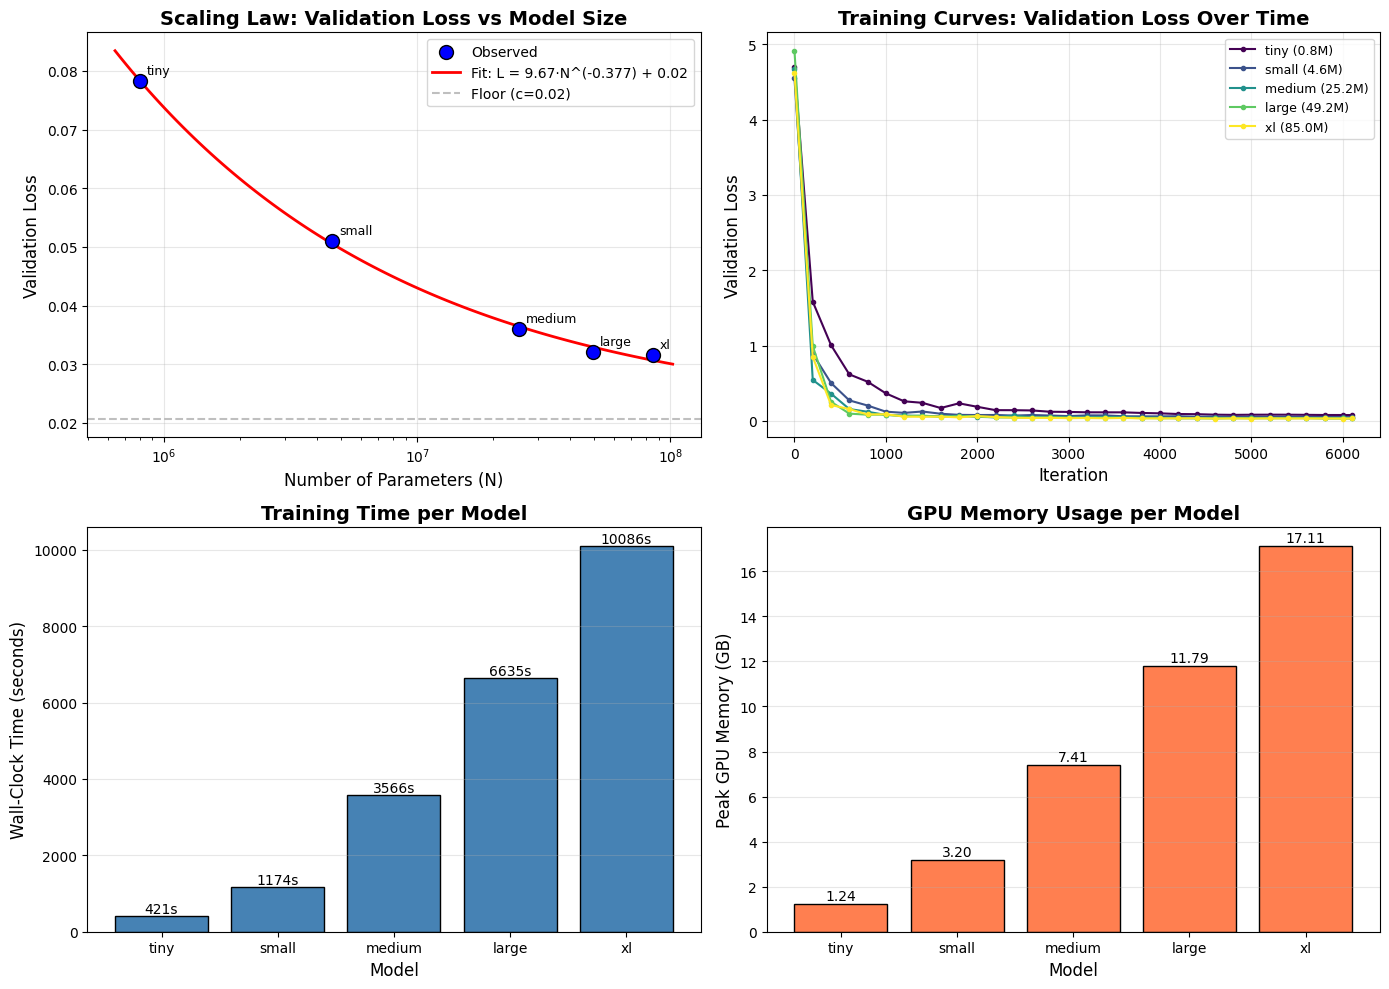


✓ Plot saved to: /content/drive/MyDrive/CS-GY 6923/Project/scaling_analysis.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: Scaling Law (Main Result) ---
ax1 = axes[0, 0]
ax1.scatter(n_params, val_losses, s=100, c='blue', edgecolors='black', zorder=5, label='Observed')

if fit_successful:
    # Plot fitted curve
    x_smooth = np.logspace(np.log10(n_params.min() * 0.8), np.log10(n_params.max() * 1.2), 100)
    y_smooth = power_law(x_smooth, *popt)
    ax1.plot(x_smooth, y_smooth, 'r-', linewidth=2, label=f'Fit: L = {a_fit:.2f}·N^(-{alpha_fit:.3f}) + {c_fit:.2f}')
    ax1.axhline(y=c_fit, color='gray', linestyle='--', alpha=0.5, label=f'Floor (c={c_fit:.2f})')

# Annotate points with model names
for i, name in enumerate(model_names):
    ax1.annotate(name, (n_params[i], val_losses[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=9)

ax1.set_xscale('log')
ax1.set_xlabel('Number of Parameters (N)', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.set_title('Scaling Law: Validation Loss vs Model Size', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Training Curves ---
ax2 = axes[0, 1]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

for i, name in enumerate(model_names):
    iterations = all_metrics[name]['iterations']
    losses = all_metrics[name]['val_losses']
    ax2.plot(iterations, losses, '-o', color=colors[i], label=f'{name} ({n_params[i]/1e6:.1f}M)', markersize=3)

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Training Curves: Validation Loss Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# --- Plot 3: Wall-Clock Time ---
ax3 = axes[1, 0]
bars = ax3.bar(model_names, wall_times, color='steelblue', edgecolor='black')
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Wall-Clock Time (seconds)', fontsize=12)
ax3.set_title('Training Time per Model', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, t in zip(bars, wall_times):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{t:.0f}s', ha='center', va='bottom', fontsize=10)

# --- Plot 4: GPU Memory Usage ---
ax4 = axes[1, 1]
bars = ax4.bar(model_names, gpu_memory, color='coral', edgecolor='black')
ax4.set_xlabel('Model', fontsize=12)
ax4.set_ylabel('Peak GPU Memory (GB)', fontsize=12)
ax4.set_title('GPU Memory Usage per Model', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mem in zip(bars, gpu_memory):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{mem:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(DIR, 'scaling_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {os.path.join(DIR, 'scaling_analysis.png')}")

#### 2.3 Track Additional Metrics

Log-log Plot

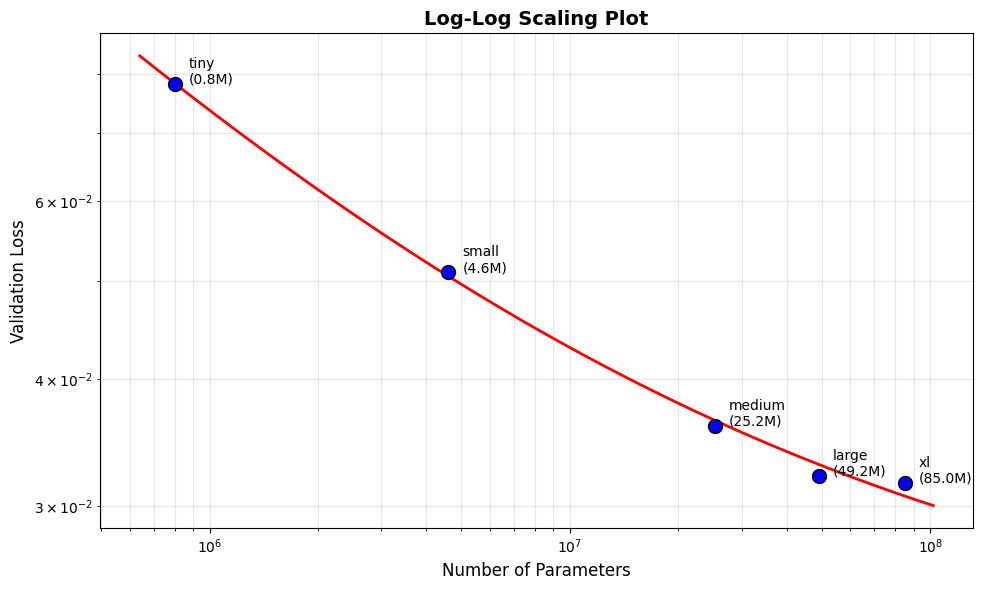

✓ Log-log plot saved to: /content/drive/MyDrive/CS-GY 6923/Project/scaling_loglog.png


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Log-log plot for power law visualization
ax.scatter(n_params, val_losses, s=100, c='blue', edgecolors='black', zorder=5)

if fit_successful:
    ax.plot(x_smooth, y_smooth, 'r-', linewidth=2)

for i, name in enumerate(model_names):
    ax.annotate(f'{name}\n({n_params[i]/1e6:.1f}M)',
                (n_params[i], val_losses[i]),
                textcoords="offset points", xytext=(10, 0), fontsize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Log-Log Scaling Plot', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(os.path.join(DIR, 'scaling_loglog.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Log-log plot saved to: {os.path.join(DIR, 'scaling_loglog.png')}")

Summary Statistics

In [ ]:
print(f"\nDataset: {len(train_data):,} training tokens")
print(f"Training budget: {SCALING_STUDY_TOKENS:,} tokens per model")
print(f"Batch size: {BATCH_SIZE} × {BLOCK_SIZE} = {TOKENS_PER_BATCH:,} tokens/batch")

print(f"\nModels trained: {len(model_names)}")
print(f"Parameter range: {n_params.min():,} → {n_params.max():,} ({n_params.max()/n_params.min():.1f}x)")
print(f"Loss range: {val_losses.max():.4f} → {val_losses.min():.4f}")

if fit_successful:
    print(f"\nScaling exponent α = {alpha_fit:.4f}")
    print(f"Loss floor c = {c_fit:.4f}")
    print(f"R² = {r_squared:.4f}")

print(f"\nTotal training time: {wall_times.sum():.1f}s ({wall_times.sum()/60:.1f} min)")
print(f"Peak GPU memory: {gpu_memory.max():.2f} GB")

# Early stopping summary
early_stopped = [name for name in model_names if all_metrics[name].get('early_stopped', False)]
if early_stopped:
    print(f"\nModels that early-stopped: {early_stopped}")
else:
    print(f"\nNo models early-stopped (all completed full training)")


Dataset: 13,594,369,550 training tokens
Training budget: 100,000,000 tokens per model
Batch size: 64 × 256 = 16,384 tokens/batch

Models trained: 5
Parameter range: 800,384 → 85,030,656 (106.2x)
Loss range: 0.0783 → 0.0316

Scaling exponent α = 0.3769
Loss floor c = 0.0208
R² = 0.9987

Total training time: 21882.0s (364.7 min)
Peak GPU memory: 17.11 GB

No models early-stopped (all completed full training)


### 3. RNN Scaling Study and Comparison

#### 3.1 LSTM Language Model Setup

In [19]:
class LSTMLanguageModel(nn.Module):
    """LSTM-based language model for comparison with Transformer."""

    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Token embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )

        # Output projection
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Tie weights if dimensions match
        if embed_dim == hidden_dim:
            self.fc.weight = self.embedding.weight

        self._init_weights()

    def _init_weights(self):
        # Initialize embeddings
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)

        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
                # Set forget gate bias to 1 for better gradient flow
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)

        # Initialize output layer
        if not hasattr(self.fc, 'weight') or self.fc.weight is not self.embedding.weight:
            nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, x, hidden=None):
        """
        Args:
            x: (batch, seq_len) token indices
            hidden: optional (h, c) tuple for stateful training
        Returns:
            logits: (batch, seq_len, vocab_size)
            hidden: (h, c) tuple
        """
        # Embed tokens
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)

        # LSTM forward pass
        if hidden is None:
            lstm_out, hidden = self.lstm(emb)
        else:
            lstm_out, hidden = self.lstm(emb, hidden)

        # Project to vocabulary
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)  # (batch, seq_len, vocab_size)

        return logits, hidden

    def init_hidden(self, batch_size, device):
        """Initialize hidden state."""
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        c = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        return (h, c)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def create_lstm_configs(vocab_size):
    """
    Create LSTM configs with parameter counts similar to transformer models.
    Target: ~1M, ~5M, ~20M, ~50M parameters

    LSTM parameter count ≈
        embed: vocab_size * embed_dim
        lstm: n_layers * (4 * hidden_dim * (embed_dim + hidden_dim) + 4 * hidden_dim)
        output: hidden_dim * vocab_size (or tied)
    """

    configs = {
        'LSTM-S': {  # Target ~1-2M
            'embed_dim': 256,
            'hidden_dim': 256,
            'n_layers': 2,
            'dropout': 0.1,
        },
        'LSTM-M': {  # Target ~5M
            'embed_dim': 384,
            'hidden_dim': 512,
            'n_layers': 2,
            'dropout': 0.1,
        },
        'LSTM-L': {  # Target ~15-20M
            'embed_dim': 512,
            'hidden_dim': 768,
            'n_layers': 3,
            'dropout': 0.1,
        },
        'LSTM-XL': {  # Target ~40-50M
            'embed_dim': 768,
            'hidden_dim': 1024,
            'n_layers': 4,
            'dropout': 0.1,
        },
    }

    # Add vocab_size to all configs
    for cfg in configs.values():
        cfg['vocab_size'] = vocab_size

    return configs

#### 3.2 Training Infrastructure

In [25]:

def train_lstm_model(config, name, train_data, val_data, total_tokens,
                     batch_size, block_size, device, eval_interval=500):
    """Train a single LSTM model and collect metrics."""

    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")

    # Create model
    model = LSTMLanguageModel(**config).to(device)
    n_params = model.count_parameters()
    print(f"Parameters: {n_params:,}")

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

    # Learning rate scheduler
    tokens_per_batch = batch_size * block_size
    total_steps = total_tokens // tokens_per_batch
    warmup_steps = min(500, total_steps // 10)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Metrics tracking
    train_losses = []
    val_losses = []
    iterations = []

    # Training loop
    model.train()
    tokens_processed = 0
    step = 0
    best_val_loss = float('inf')

    # GPU memory tracking
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    while tokens_processed < total_tokens:
        # Get batch - convert to long tensor for embeddings
        ix = torch.randint(len(train_data) - block_size - 1, (batch_size,))
        x = torch.stack([torch.from_numpy(np.array(train_data[i:i+block_size]).astype(np.int64)) for i in ix]).to(device)
        y = torch.stack([torch.from_numpy(np.array(train_data[i+1:i+block_size+1]).astype(np.int64)) for i in ix]).to(device)

        # Forward pass
        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        tokens_processed += tokens_per_batch
        step += 1

        # Evaluation
        if step % eval_interval == 0 or tokens_processed >= total_tokens:
            val_loss = evaluate_lstm(model, val_data, block_size, batch_size, device)
            train_losses.append(loss.item())
            val_losses.append(val_loss)
            iterations.append(step)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

            elapsed = time.time() - start_time
            pct = 100 * tokens_processed / total_tokens
            print(f"  Step {step:5d} | {pct:5.1f}% | Train: {loss.item():.4f} | Val: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

    # Final metrics
    wall_time = time.time() - start_time

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.max_memory_allocated() / 1e9
    else:
        gpu_memory = 0

    metrics = {
        'name': name,
        'config': config,
        'n_params': n_params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_train_loss': train_losses[-1],
        'best_val_loss': best_val_loss,
        'wall_time_seconds': wall_time,
        'gpu_memory_gb': gpu_memory,
        'tokens_per_second': total_tokens / wall_time,
    }

    print(f"\n  ✓ Completed {name}")
    print(f"    Best val loss: {best_val_loss:.4f}")
    print(f"    Wall time: {wall_time:.1f}s")
    print(f"    Throughput: {total_tokens/wall_time:,.0f} tokens/sec")

    return model, metrics


@torch.no_grad()
def evaluate_lstm(model, data, block_size, batch_size, device, eval_iters=50):
    """Evaluate LSTM model."""
    model.eval()
    losses = []

    for _ in range(eval_iters):
        ix = torch.randint(len(data) - block_size - 1, (batch_size,))
        x = torch.stack([torch.from_numpy(np.array(data[i:i+block_size]).astype(np.int64)) for i in ix]).to(device)
        y = torch.stack([torch.from_numpy(np.array(data[i+1:i+block_size+1]).astype(np.int64)) for i in ix]).to(device)

        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        losses.append(loss.item())

    model.train()
    return np.mean(losses)

#### 3.3 Run LSTM Scaling Study

In [26]:
# Create LSTM configurations
lstm_configs = create_lstm_configs(vocab_size)

# Preview configurations
print("\nLSTM Model Configurations:")
print("-" * 60)
for name, cfg in lstm_configs.items():
    model = LSTMLanguageModel(**cfg)
    n_params = model.count_parameters()
    print(f"  {name}: {n_params:,} parameters")
    print(f"    embed_dim={cfg['embed_dim']}, hidden_dim={cfg['hidden_dim']}, n_layers={cfg['n_layers']}")
    del model
print("-" * 60)

# Training
lstm_metrics = {}

for name, cfg in lstm_configs.items():
    model, metrics = train_lstm_model(
        config=cfg,
        name=name,
        train_data=train_data,
        val_data=val_data,
        total_tokens=SCALING_STUDY_TOKENS,
        batch_size=BATCH_SIZE,
        block_size=BLOCK_SIZE,
        device=device,
        eval_interval=500
    )
    lstm_metrics[name] = metrics

    # Clean up
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save LSTM results
lstm_results_path = os.path.join(DIR, "lstm_scaling_results.pkl")
with open(lstm_results_path, 'wb') as f:
    pickle.dump(lstm_metrics, f)
print(f"\n✓ LSTM results saved to {lstm_results_path}")


LSTM Model Configurations:
------------------------------------------------------------
  LSTM-S: 1,078,372 parameters
    embed_dim=256, hidden_dim=256, n_layers=2
  LSTM-M: 4,030,052 parameters
    embed_dim=384, hidden_dim=512, n_layers=2
  LSTM-L: 13,515,876 parameters
    embed_dim=512, hidden_dim=768, n_layers=3
  LSTM-XL: 32,717,924 parameters
    embed_dim=768, hidden_dim=1024, n_layers=4
------------------------------------------------------------

Training LSTM-S
Parameters: 1,078,372
  Step   500 |   8.2% | Train: 0.7412 | Val: 1.4145 | LR: 1.00e-03
  Step  1000 |  16.4% | Train: 0.4487 | Val: 0.6221 | LR: 9.80e-04
  Step  1500 |  24.6% | Train: 0.3963 | Val: 0.1601 | LR: 9.23e-04
  Step  2000 |  32.8% | Train: 0.4211 | Val: 0.1249 | LR: 8.33e-04
  Step  2500 |  41.0% | Train: 0.2532 | Val: 0.1078 | LR: 7.17e-04
  Step  3000 |  49.2% | Train: 0.2480 | Val: 0.0884 | LR: 5.84e-04
  Step  3500 |  57.3% | Train: 0.2309 | Val: 0.0807 | LR: 4.44e-04
  Step  4000 |  65.5% | Train:

#### 3.4 Power Law Fit for LSTM

In [27]:
# Extract LSTM data
lstm_names = list(lstm_metrics.keys())
lstm_params = np.array([lstm_metrics[m]['n_params'] for m in lstm_names])
lstm_val_losses = np.array([lstm_metrics[m]['best_val_loss'] for m in lstm_names])
lstm_wall_times = np.array([lstm_metrics[m]['wall_time_seconds'] for m in lstm_names])
lstm_gpu_memory = np.array([lstm_metrics[m]['gpu_memory_gb'] for m in lstm_names])
lstm_throughput = np.array([lstm_metrics[m]['tokens_per_second'] for m in lstm_names])

# Print LSTM summary
print(f"\n{'Model':<10} {'Params':<12} {'Val Loss':<10} {'Time (s)':<10} {'GPU (GB)':<10}")
print("-" * 55)
for i, name in enumerate(lstm_names):
    print(f"{name:<10} {lstm_params[i]:<12,} {lstm_val_losses[i]:<10.4f} {lstm_wall_times[i]:<10.1f} {lstm_gpu_memory[i]:<10.2f}")

# Fit power law for LSTM
def power_law(N, a, alpha, c):
    return a * np.power(N, -alpha) + c

try:
    lstm_popt, lstm_pcov = curve_fit(
        power_law, lstm_params, lstm_val_losses,
        p0=[10.0, 0.1, 1.0],
        bounds=([0, 0, 0], [np.inf, 2, np.inf]),
        maxfev=10000
    )
    lstm_a, lstm_alpha, lstm_c = lstm_popt
    lstm_perr = np.sqrt(np.diag(lstm_pcov))

    # R-squared
    lstm_pred = power_law(lstm_params, *lstm_popt)
    lstm_ss_res = np.sum((lstm_val_losses - lstm_pred) ** 2)
    lstm_ss_tot = np.sum((lstm_val_losses - np.mean(lstm_val_losses)) ** 2)
    lstm_r2 = 1 - (lstm_ss_res / lstm_ss_tot)

    print(f"\nLSTM Power Law Fit: L = {lstm_a:.2f} · N^(-{lstm_alpha:.4f}) + {lstm_c:.2f}")
    print(f"  α = {lstm_alpha:.4f} ± {lstm_perr[1]:.4f}")
    print(f"  R² = {lstm_r2:.4f}")
    lstm_fit_success = True
except Exception as e:
    print(f"⚠ LSTM power law fit failed: {e}")
    lstm_fit_success = False


Model      Params       Val Loss   Time (s)   GPU (GB)  
-------------------------------------------------------
LSTM-S     1,078,372    0.0736     178.9      0.46      
LSTM-M     4,030,052    0.0493     222.5      0.88      
LSTM-L     13,515,876   0.0407     628.1      1.72      
LSTM-XL    32,717,924   0.0363     1829.3     3.00      

LSTM Power Law Fit: L = 410.80 · N^(-0.6629) + 0.03
  α = 0.6629 ± 0.0713
  R² = 0.9993


#### 3.5 Compare Transformer and LSTM Results

In [28]:
# Load transformer results
transformer_results_path = os.path.join(DIR, "scaling_study_results.pkl")
with open(transformer_results_path, 'rb') as f:
    transformer_metrics = pickle.load(f)

# Extract transformer data
tf_names = list(transformer_metrics.keys())
tf_params = np.array([transformer_metrics[m]['n_params'] for m in tf_names])
tf_val_losses = np.array([transformer_metrics[m]['best_val_loss'] for m in tf_names])
tf_wall_times = np.array([transformer_metrics[m]['wall_time_seconds'] for m in tf_names])
tf_gpu_memory = np.array([transformer_metrics[m]['gpu_memory_gb'] for m in tf_names])
tf_throughput = np.array([transformer_metrics[m]['tokens_per_second'] for m in tf_names])

# Fit power law for transformer
try:
    tf_popt, tf_pcov = curve_fit(
        power_law, tf_params, tf_val_losses,
        p0=[10.0, 0.1, 1.0],
        bounds=([0, 0, 0], [np.inf, 2, np.inf]),
        maxfev=10000
    )
    tf_a, tf_alpha, tf_c = tf_popt
    tf_perr = np.sqrt(np.diag(tf_pcov))

    tf_pred = power_law(tf_params, *tf_popt)
    tf_ss_res = np.sum((tf_val_losses - tf_pred) ** 2)
    tf_ss_tot = np.sum((tf_val_losses - np.mean(tf_val_losses)) ** 2)
    tf_r2 = 1 - (tf_ss_res / tf_ss_tot)

    print(f"\nTransformer Power Law: L = {tf_a:.2f} · N^(-{tf_alpha:.4f}) + {tf_c:.2f}")
    print(f"  α = {tf_alpha:.4f} ± {tf_perr[1]:.4f}")
    print(f"  R² = {tf_r2:.4f}")
    tf_fit_success = True
except Exception as e:
    print(f"⚠ Transformer power law fit failed: {e}")
    tf_fit_success = False


Transformer Power Law: L = 9.67 · N^(-0.3769) + 0.02
  α = 0.3769 ± 0.0471
  R² = 0.9987


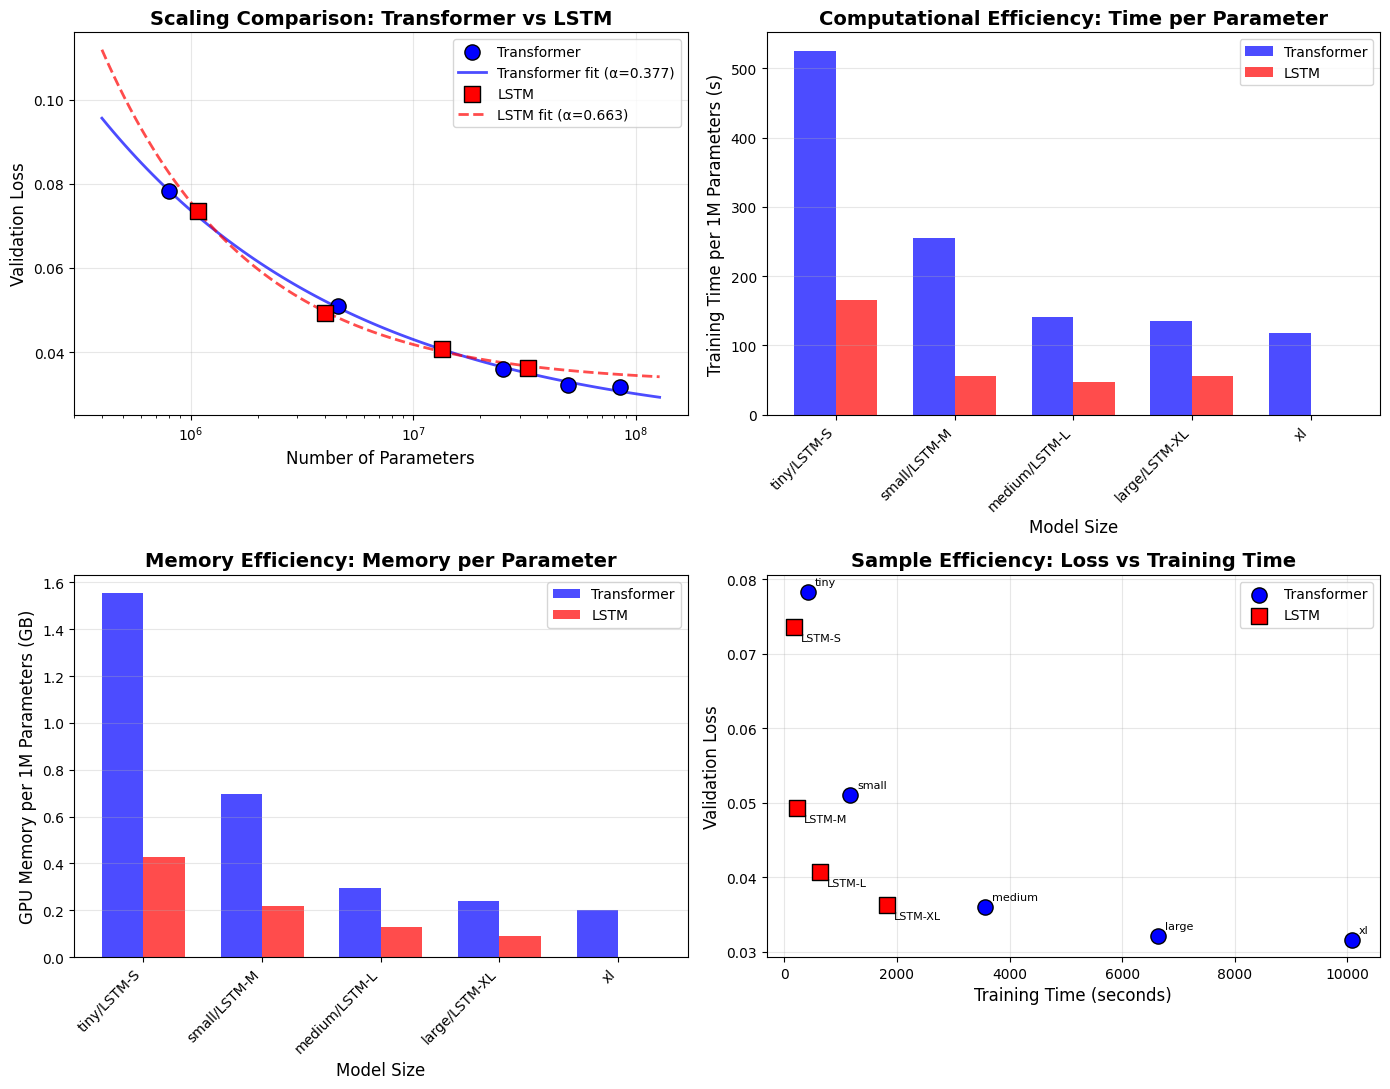


✓ Comparison plot saved to: /content/drive/MyDrive/CS-GY 6923/Project/transformer_vs_lstm_comparison.png


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# --- Plot 1: Scaling Comparison (Main Result) ---
ax1 = axes[0, 0]

# Transformer points and fit
ax1.scatter(tf_params, tf_val_losses, s=120, c='blue', marker='o',
            edgecolors='black', zorder=5, label='Transformer')
if tf_fit_success:
    x_smooth = np.logspace(np.log10(min(tf_params.min(), lstm_params.min()) * 0.5),
                           np.log10(max(tf_params.max(), lstm_params.max()) * 1.5), 100)
    ax1.plot(x_smooth, power_law(x_smooth, *tf_popt), 'b-', linewidth=2, alpha=0.7,
             label=f'Transformer fit (α={tf_alpha:.3f})')

# LSTM points and fit
ax1.scatter(lstm_params, lstm_val_losses, s=120, c='red', marker='s',
            edgecolors='black', zorder=5, label='LSTM')
if lstm_fit_success:
    ax1.plot(x_smooth, power_law(x_smooth, *lstm_popt), 'r--', linewidth=2, alpha=0.7,
             label=f'LSTM fit (α={lstm_alpha:.3f})')

ax1.set_xscale('log')
ax1.set_xlabel('Number of Parameters', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.set_title('Scaling Comparison: Transformer vs LSTM', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Training Efficiency (Time per Parameter) ---
ax2 = axes[0, 1]

# Time per million parameters
tf_time_per_param = tf_wall_times / (tf_params / 1e6)
lstm_time_per_param = lstm_wall_times / (lstm_params / 1e6)

n_tf = len(tf_names)
n_lstm = len(lstm_names)
n_groups = max(n_tf, n_lstm)
x_pos = np.arange(n_groups)
width = 0.35

# Create grouped bars - pad with zeros if needed
tf_time_padded = np.zeros(n_groups)
tf_time_padded[:n_tf] = tf_time_per_param
lstm_time_padded = np.zeros(n_groups)
lstm_time_padded[:n_lstm] = lstm_time_per_param

tf_bars = ax2.bar(x_pos - width/2, tf_time_padded, width,
                  label='Transformer', color='blue', alpha=0.7)
lstm_bars = ax2.bar(x_pos + width/2, lstm_time_padded, width,
                    label='LSTM', color='red', alpha=0.7)

# Create labels based on actual model names
size_labels = []
for i in range(n_groups):
    tf_label = tf_names[i] if i < n_tf else ''
    lstm_label = lstm_names[i] if i < n_lstm else ''
    if tf_label and lstm_label:
        size_labels.append(f"{tf_label}/{lstm_label}")
    else:
        size_labels.append(tf_label or lstm_label)

ax2.set_xlabel('Model Size', fontsize=12)
ax2.set_ylabel('Training Time per 1M Parameters (s)', fontsize=12)
ax2.set_title('Computational Efficiency: Time per Parameter', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(size_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# --- Plot 3: Memory Efficiency ---
ax3 = axes[1, 0]

# Memory per million parameters
tf_mem_per_param = tf_gpu_memory / (tf_params / 1e6)
lstm_mem_per_param = lstm_gpu_memory / (lstm_params / 1e6)

tf_mem_padded = np.zeros(n_groups)
tf_mem_padded[:n_tf] = tf_mem_per_param
lstm_mem_padded = np.zeros(n_groups)
lstm_mem_padded[:n_lstm] = lstm_mem_per_param

tf_bars = ax3.bar(x_pos - width/2, tf_mem_padded, width,
                  label='Transformer', color='blue', alpha=0.7)
lstm_bars = ax3.bar(x_pos + width/2, lstm_mem_padded, width,
                    label='LSTM', color='red', alpha=0.7)

ax3.set_xlabel('Model Size', fontsize=12)
ax3.set_ylabel('GPU Memory per 1M Parameters (GB)', fontsize=12)
ax3.set_title('Memory Efficiency: Memory per Parameter', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(size_labels, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# --- Plot 4: Loss vs Compute (Training Time) ---
ax4 = axes[1, 1]

ax4.scatter(tf_wall_times, tf_val_losses, s=120, c='blue', marker='o',
            edgecolors='black', zorder=5, label='Transformer')
ax4.scatter(lstm_wall_times, lstm_val_losses, s=120, c='red', marker='s',
            edgecolors='black', zorder=5, label='LSTM')

# Annotate with model names
for i, name in enumerate(tf_names):
    ax4.annotate(name, (tf_wall_times[i], tf_val_losses[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8)
for i, name in enumerate(lstm_names):
    ax4.annotate(name, (lstm_wall_times[i], lstm_val_losses[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8)

ax4.set_xlabel('Training Time (seconds)', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.set_title('Sample Efficiency: Loss vs Training Time', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DIR, 'transformer_vs_lstm_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved to: {os.path.join(DIR, 'transformer_vs_lstm_comparison.png')}")

In [31]:
print("\n" + "=" * 70)
print("DETAILED COMPARATIVE ANALYSIS")
print("=" * 70)

print("\n" + "-" * 50)
print("1. SCALING EXPONENTS")
print("-" * 50)
if tf_fit_success and lstm_fit_success:
    print(f"   Transformer α = {tf_alpha:.4f}")
    print(f"   LSTM α = {lstm_alpha:.4f}")

    if tf_alpha > lstm_alpha:
        ratio = tf_alpha / lstm_alpha
        print(f"\n   → Transformer scales {ratio:.2f}x better (steeper exponent)")
        print(f"   → With 10x more parameters:")
        print(f"      Transformer loss reduction: {(1 - 10**(-tf_alpha))*100:.1f}%")
        print(f"      LSTM loss reduction: {(1 - 10**(-lstm_alpha))*100:.1f}%")
    else:
        ratio = lstm_alpha / tf_alpha
        print(f"\n   → LSTM scales {ratio:.2f}x better (steeper exponent)")

print("\n" + "-" * 50)
print("2. ABSOLUTE PERFORMANCE")
print("-" * 50)

# Find comparable parameter counts
print("\n   At similar parameter counts:")
for tf_name, lstm_name in zip(tf_names, lstm_names):
    tf_p = transformer_metrics[tf_name]['n_params']
    lstm_p = lstm_metrics[lstm_name]['n_params']
    tf_l = transformer_metrics[tf_name]['best_val_loss']
    lstm_l = lstm_metrics[lstm_name]['best_val_loss']

    print(f"   {tf_name} ({tf_p/1e6:.1f}M): {tf_l:.4f} vs {lstm_name} ({lstm_p/1e6:.1f}M): {lstm_l:.4f}")
    if tf_l < lstm_l:
        print(f"      → Transformer better by {(lstm_l - tf_l):.4f} ({(lstm_l/tf_l - 1)*100:.1f}%)")
    else:
        print(f"      → LSTM better by {(tf_l - lstm_l):.4f} ({(tf_l/lstm_l - 1)*100:.1f}%)")

print("\n" + "-" * 50)
print("3. COMPUTATIONAL EFFICIENCY")
print("-" * 50)

avg_tf_throughput = np.mean(tf_throughput)
avg_lstm_throughput = np.mean(lstm_throughput)
print(f"\n   Average throughput:")
print(f"   Transformer: {avg_tf_throughput:,.0f} tokens/sec")
print(f"   LSTM: {avg_lstm_throughput:,.0f} tokens/sec")
print(f"   Ratio: {avg_tf_throughput/avg_lstm_throughput:.2f}x")

print(f"\n   Total training time:")
print(f"   Transformer: {tf_wall_times.sum():.1f}s")
print(f"   LSTM: {lstm_wall_times.sum():.1f}s")

print("\n" + "-" * 50)
print("4. MEMORY EFFICIENCY")
print("-" * 50)
print(f"\n   Peak GPU memory:")
print(f"   Transformer: {tf_gpu_memory.max():.2f} GB (largest model)")
print(f"   LSTM: {lstm_gpu_memory.max():.2f} GB (largest model)")

print("\n" + "-" * 50)
print("5. WHY THESE DIFFERENCES?")
print("-" * 50)
print("""
   ARCHITECTURAL DIFFERENCES:

   Transformer advantages:
   • Self-attention captures long-range dependencies directly
   • Parallel processing of all positions (vs sequential in LSTM)
   • Better gradient flow through residual connections
   • Scales more efficiently with sequence length (for moderate lengths)

   LSTM advantages:
   • More parameter-efficient for very small models
   • Lower memory for very long sequences (O(1) vs O(n²) attention)
   • Simpler inductive bias for sequential data
   • Can be faster for inference on sequential generation

   SCALING BEHAVIOR:
   • Transformers typically show stronger scaling (higher α)
   • LSTMs may plateau earlier due to vanishing gradients
   • Transformer architecture enables better utilization of parameters
   • Attention mechanism provides more expressive capacity per parameter
""")

print("\n" + "-" * 50)
print("6. SAMPLE EFFICIENCY vs COMPUTE EFFICIENCY")
print("-" * 50)

# For same compute budget (time), which achieves lower loss?
print("\n   At similar training times, which achieves lower loss?")
for tf_idx, lstm_idx in zip(range(len(tf_names)), range(len(lstm_names))):
    tf_time = tf_wall_times[tf_idx]
    lstm_time = lstm_wall_times[lstm_idx]
    tf_loss = tf_val_losses[tf_idx]
    lstm_loss = lstm_val_losses[lstm_idx]

    # Find closest time match
    print(f"   {tf_names[tf_idx]} ({tf_time:.0f}s, loss={tf_loss:.4f}) vs "
          f"{lstm_names[lstm_idx]} ({lstm_time:.0f}s, loss={lstm_loss:.4f})")


DETAILED COMPARATIVE ANALYSIS

--------------------------------------------------
1. SCALING EXPONENTS
--------------------------------------------------
   Transformer α = 0.3769
   LSTM α = 0.6629

   → LSTM scales 1.76x better (steeper exponent)

--------------------------------------------------
2. ABSOLUTE PERFORMANCE
--------------------------------------------------

   At similar parameter counts:
   tiny (0.8M): 0.0783 vs LSTM-S (1.1M): 0.0736
      → LSTM better by 0.0047 (6.3%)
   small (4.6M): 0.0510 vs LSTM-M (4.0M): 0.0493
      → LSTM better by 0.0017 (3.5%)
   medium (25.2M): 0.0360 vs LSTM-L (13.5M): 0.0407
      → Transformer better by 0.0047 (13.1%)
   large (49.2M): 0.0321 vs LSTM-XL (32.7M): 0.0363
      → Transformer better by 0.0042 (13.1%)

--------------------------------------------------
3. COMPUTATIONAL EFFICIENCY
--------------------------------------------------

   Average throughput:
   Transformer: 75,162 tokens/sec
   LSTM: 305,551 tokens/sec
   Ratio

In [35]:
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)

print(f"\n{'Metric':<30} {'Transformer':<20} {'LSTM':<20}")
print("-" * 70)
if tf_fit_success and lstm_fit_success:
    print(f"{'Scaling exponent (α)':<30} {tf_alpha:<20.4f} {lstm_alpha:<20.4f}")
    print(f"{'Loss floor (c)':<30} {tf_c:<20.4f} {lstm_c:<20.4f}")
print(f"{'Best validation loss':<30} {tf_val_losses.min():<20.4f} {lstm_val_losses.min():<20.4f}")
print(f"{'Avg throughput (tok/s)':<30} {avg_tf_throughput:<20,.0f} {avg_lstm_throughput:<20,.0f}")
print(f"{'Total training time (s)':<30} {tf_wall_times.sum():<20.1f} {lstm_wall_times.sum():<20.1f}")
print(f"{'Peak GPU memory (GB)':<30} {tf_gpu_memory.max():<20.2f} {lstm_gpu_memory.max():<20.2f}")
print("-" * 70)

# Save all comparison data
comparison_data = {
    'transformer': transformer_metrics,
    'lstm': lstm_metrics,
    'transformer_fit': {'a': tf_a, 'alpha': tf_alpha, 'c': tf_c, 'r2': tf_r2} if tf_fit_success else None,
    'lstm_fit': {'a': lstm_a, 'alpha': lstm_alpha, 'c': lstm_c, 'r2': lstm_r2} if lstm_fit_success else None,
}

comparison_path = os.path.join(DIR, "architecture_comparison.pkl")
with open(comparison_path, 'wb') as f:
    pickle.dump(comparison_data, f)
print(f"\n✓ All comparison data saved to: {comparison_path}")


SUMMARY TABLE

Metric                         Transformer          LSTM                
----------------------------------------------------------------------
Scaling exponent (α)           0.3769               0.6629              
Loss floor (c)                 0.0208               0.0324              
Best validation loss           0.0316               0.0363              
Avg throughput (tok/s)         75,162               305,551             
Total training time (s)        21882.0              2858.8              
Peak GPU memory (GB)           17.11                3.00                
----------------------------------------------------------------------

✓ All comparison data saved to: /content/drive/MyDrive/CS-GY 6923/Project/architecture_comparison.pkl


#### 3.6 Part 3 Results Checkpoint

In [5]:
# Load results if not already in memory

DIR = "/content/drive/MyDrive/CS-GY 6923/Project"
ABC_EXTRACT_DIR = "/content/lmd_full_abc"  # Local storage for faster access

# Load Transformer results
if 'all_metrics' not in dir() or len(all_metrics) == 0:
    results_path = os.path.join(DIR, "scaling_study_results.pkl")
    with open(results_path, 'rb') as f:
        all_metrics = pickle.load(f)
    print(f"✓ Loaded Transformer results from {results_path}")

# Load LSTM results
if 'lstm_metrics' not in dir() or len(lstm_metrics) == 0:
    lstm_results_path = os.path.join(DIR, "lstm_scaling_results.pkl")
    with open(lstm_results_path, 'rb') as f:
        lstm_metrics = pickle.load(f)
    print(f"✓ Loaded LSTM results from {lstm_results_path}")

# Extract Transformer data
tf_names = list(all_metrics.keys())
tf_params = np.array([all_metrics[m]['n_params'] for m in tf_names])
tf_val_losses = np.array([all_metrics[m]['best_val_loss'] for m in tf_names])
tf_train_losses = np.array([all_metrics[m]['final_train_loss'] for m in tf_names])
tf_wall_times = np.array([all_metrics[m]['wall_time_seconds'] for m in tf_names])
tf_gpu_memory = np.array([all_metrics[m]['gpu_memory_gb'] for m in tf_names])
tf_tokens_per_sec = np.array([all_metrics[m]['tokens_per_second'] for m in tf_names])

# Extract LSTM data
lstm_names = list(lstm_metrics.keys())
lstm_params = np.array([lstm_metrics[m]['n_params'] for m in lstm_names])
lstm_val_losses = np.array([lstm_metrics[m]['best_val_loss'] for m in lstm_names])
lstm_train_losses = np.array([lstm_metrics[m]['final_train_loss'] for m in lstm_names])
lstm_wall_times = np.array([lstm_metrics[m]['wall_time_seconds'] for m in lstm_names])
lstm_gpu_memory = np.array([lstm_metrics[m]['gpu_memory_gb'] for m in lstm_names])
lstm_tokens_per_sec = np.array([lstm_metrics[m]['tokens_per_second'] for m in lstm_names])

# Print Transformer summary table
print(f"\n{'='*90}")
print("TRANSFORMER MODELS")
print(f"{'='*90}")
print(f"{'Model':<12} {'Params':<14} {'Val Loss':<10} {'Train Loss':<12} {'Time (s)':<10} {'GPU (GB)':<10} {'Tok/s':<12}")
print("-" * 90)
for i, name in enumerate(tf_names):
    print(f"{name:<12} {tf_params[i]:<14,} {tf_val_losses[i]:<10.4f} {tf_train_losses[i]:<12.4f} {tf_wall_times[i]:<10.1f} {tf_gpu_memory[i]:<10.2f} {tf_tokens_per_sec[i]:<12,.0f}")

# Print LSTM summary table
print(f"\n{'='*90}")
print("LSTM MODELS")
print(f"{'='*90}")
print(f"{'Model':<12} {'Params':<14} {'Val Loss':<10} {'Train Loss':<12} {'Time (s)':<10} {'GPU (GB)':<10} {'Tok/s':<12}")
print("-" * 90)
for i, name in enumerate(lstm_names):
    print(f"{name:<12} {lstm_params[i]:<14,} {lstm_val_losses[i]:<10.4f} {lstm_train_losses[i]:<12.4f} {lstm_wall_times[i]:<10.1f} {lstm_gpu_memory[i]:<10.2f} {lstm_tokens_per_sec[i]:<12,.0f}")

# Print comparison summary
print(f"\n{'='*90}")
print("ARCHITECTURE COMPARISON SUMMARY")
print(f"{'='*90}")
print(f"{'Metric':<30} {'Transformer':<25} {'LSTM':<25}")
print("-" * 90)
print(f"{'Number of models':<30} {len(tf_names):<25} {len(lstm_names):<25}")
print(f"{'Parameter range':<30} {tf_params.min():,} - {tf_params.max():,}  {lstm_params.min():,} - {lstm_params.max():,}")
print(f"{'Best validation loss':<30} {tf_val_losses.min():.4f} ({tf_names[np.argmin(tf_val_losses)]})       {lstm_val_losses.min():.4f} ({lstm_names[np.argmin(lstm_val_losses)]})")
print(f"{'Avg tokens/sec':<30} {tf_tokens_per_sec.mean():,.0f}                 {lstm_tokens_per_sec.mean():,.0f}")
print(f"{'Total training time':<30} {tf_wall_times.sum():.1f}s                   {lstm_wall_times.sum():.1f}s")

✓ Loaded Transformer results from /content/drive/MyDrive/CS-GY 6923/Project/scaling_study_results.pkl
✓ Loaded LSTM results from /content/drive/MyDrive/CS-GY 6923/Project/lstm_scaling_results.pkl

TRANSFORMER MODELS
Model        Params         Val Loss   Train Loss   Time (s)   GPU (GB)   Tok/s       
------------------------------------------------------------------------------------------
tiny         800,384        0.0783     0.2790       420.8      1.24       237,621     
small        4,600,764      0.0510     0.2064       1174.1     3.20       85,166      
medium       25,225,728     0.0360     0.1595       3566.3     7.41       28,038      
large        49,229,440     0.0321     0.1593       6634.6     11.79      15,071      
xl           85,030,656     0.0316     0.1595       10086.2    17.11      9,914       

LSTM MODELS
Model        Params         Val Loss   Train Loss   Time (s)   GPU (GB)   Tok/s       
-----------------------------------------------------------------------

### 4. Best Model Training and Sample Generation

Based on the results earlier, the xl transformer model had the lowest loss.

#### 4.1 Load Best Model

In [32]:
best_model_name = 'xl'
checkpoint_path = os.path.join(DIR, f"model_{best_model_name}.pt")
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Recreate model
config = checkpoint['config']
best_model = GPT(config).to(device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

print(f"Loaded {best_model_name} model with {checkpoint['metrics']['n_params']:,} parameters")
print(f"Best validation loss: {checkpoint['metrics']['best_val_loss']:.4f}")

Loaded xl model with 85,030,656 parameters
Best validation loss: 0.0316


#### 4.2 Sample Generation Function

In [33]:
def generate_abc_sample(model, prompt=None, max_tokens=512, temperature=1.0, top_k=50):
    """
    Generate ABC notation sample

    Args:
        model: trained GPT model
        prompt: optional starting text (for conditional generation)
        max_tokens: maximum tokens to generate
        temperature: sampling temperature
        top_k: top-k sampling parameter

    Returns:
        generated ABC notation string
    """
    model.eval()

    if prompt is None:
        # Unconditional: start with standard ABC header
        prompt = "X: 1\nT: Generated Tune\nM: 4/4\nL: 1/8\nK:C\n"

    # Encode prompt
    tokens = encode(prompt)
    idx = torch.tensor([tokens], dtype=torch.long, device=device)

    # Generate
    with torch.no_grad():
        generated = model.generate(idx, max_new_tokens=max_tokens, temperature=temperature, top_k=top_k)

    # Decode
    output = decode(generated[0].tolist())
    return output

#### 4.3 Generate Samples

Unconditional samples: The model generates a music sample on its own.

Conditional Samples: The model is given certain prompts that it must consider when generating its music samples.

In [40]:
samples = []

# Unconditional samples
print("\nGenerating unconditional samples...")
for i in range(10): # Generate 10 unconditional samples
    sample = generate_abc_sample(best_model, prompt=None, temperature=0.9, top_k=40)
    samples.append({
        'type': 'unconditional',
        'id': i+1,
        'content': sample
    })
    print(f"  Sample {i+1} generated ({len(sample)} chars)")

# Conditional samples with different keys/meters
print("\nGenerating conditional samples...")
conditional_prompts = [
    "X: 1\nT: Waltz\nM: 3/4\nL: 1/8\nK:G\n",
    "X: 1\nT: March\nM: 4/4\nL: 1/8\nK:D\n",
    "X: 1\nT: Jig\nM: 6/8\nL: 1/8\nK:Am\n",
    "X: 1\nT: Blues\nM: 4/4\nL: 1/8\nK:E\n",
    "X: 1\nT: Reel\nM: 4/4\nL: 1/8\nK:G\nV:1\n|: GABc |",
    "X: 1\nT: Slow Air\nM: 3/4\nL: 1/4\nK:Cmaj\n",
    "X: 1\nT: Fast Breakdown\nM: 2/4\nL: 1/16\nK:Gmix\n",
    "X: 1\nT: Ballad\nM: 4/4\nL: 1/4\nK:Dmin\n",
    "X: 1\nT: Polka\nM: 2/4\nL: 1/8\nK:F\n",
    "X: 1\nT: Hymn\nM: 4/4\nL: 1/2\nK:Bb\n"
]

for i, prompt in enumerate(conditional_prompts):
    sample = generate_abc_sample(best_model, prompt=prompt, temperature=0.85, top_k=50)
    samples.append({
        'type': 'conditional',
        'id': i+1,
        'prompt': prompt,
        'content': sample
    })
    print(f"  Conditional sample {i+1} generated ({len(sample)} chars)")


Generating unconditional samples...
  Sample 1 generated (553 chars)
  Sample 2 generated (553 chars)
  Sample 3 generated (553 chars)
  Sample 4 generated (553 chars)
  Sample 5 generated (553 chars)
  Sample 6 generated (553 chars)
  Sample 7 generated (553 chars)
  Sample 8 generated (553 chars)
  Sample 9 generated (553 chars)
  Sample 10 generated (553 chars)

Generating conditional samples...
  Conditional sample 1 generated (544 chars)
  Conditional sample 2 generated (544 chars)
  Conditional sample 3 generated (543 chars)
  Conditional sample 4 generated (544 chars)
  Conditional sample 5 generated (556 chars)
  Conditional sample 6 generated (550 chars)
  Conditional sample 7 generated (557 chars)
  Conditional sample 8 generated (548 chars)
  Conditional sample 9 generated (544 chars)
  Conditional sample 10 generated (544 chars)


#### 4.4 Quantitative Evaluation

In [43]:
def calculate_test_perplexity(model, test_data, block_size=256, batch_size=32, num_batches=100):
    """Calculate perplexity on test set"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for _ in range(num_batches):
            ix = torch.randint(len(test_data) - block_size, (batch_size,))
            x = torch.stack([torch.from_numpy(test_data[i:i+block_size].astype(np.int64)) for i in ix])
            y = torch.stack([torch.from_numpy(test_data[i+1:i+1+block_size].astype(np.int64)) for i in ix])
            x, y = x.to(device), y.to(device)

            _, loss = model(x, y)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

# Test set perplexity
test_loss, test_perplexity = calculate_test_perplexity(best_model, test_data)
print(f"\nFinal Test Set Metrics:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Perplexity: {test_perplexity:.2f}")

def check_abc_syntax(abc_string):
    """Check if ABC notation is syntactically valid"""
    # Basic checks
    has_x = 'X:' in abc_string
    has_key = 'K:' in abc_string
    has_notes = any(c in abc_string for c in 'ABCDEFGabcdefg')
    has_barlines = '|' in abc_string

    # Check for balanced brackets/parens
    balanced = abc_string.count('[') == abc_string.count(']')
    balanced = balanced and abc_string.count('(') == abc_string.count(')')

    return has_x and has_key and has_notes and has_barlines and balanced

def try_convert_to_midi(abc_string, output_path):
    """Try to convert ABC to MIDI using abc2midi"""
    try:
        # Write ABC to temp file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.abc', delete=False) as f:
            f.write(abc_string)
            abc_path = f.name

        # Run abc2midi
        result = subprocess.run(
            ['abc2midi', abc_path, '-o', output_path],
            capture_output=True,
            timeout=10
        )

        # Check if MIDI was created
        success = os.path.exists(output_path) and os.path.getsize(output_path) > 0

        # Cleanup
        os.unlink(abc_path)

        return success
    except Exception as e:
        return False

# Evaluate samples
print("\nEvaluating generated samples...")
valid_syntax = 0
midi_convertible = 0

for sample in samples:
    # Syntax check
    if check_abc_syntax(sample['content']):
        valid_syntax += 1
        sample['valid_syntax'] = True
    else:
        sample['valid_syntax'] = False

    # MIDI conversion check
    # Create a unique midi path for each sample
    midi_path = f"/content/sample_{sample['type']}_{sample['id']}.mid"
    if try_convert_to_midi(sample['content'], midi_path):
        midi_convertible += 1
        sample['midi_convertible'] = True
        sample['midi_path'] = midi_path
    else:
        sample['midi_convertible'] = False

print(f"\nSample Quality Metrics:")
print(f"  Total samples: {len(samples)}")
print(f"  Syntactically valid: {valid_syntax}/{len(samples)} ({100*valid_syntax/len(samples):.1f}%)")
print(f"  Successfully converted to MIDI: {midi_convertible}/{len(samples)} ({100*midi_convertible/len(samples):.1f}%)")


Final Test Set Metrics:
  Test Loss: 0.1883
  Test Perplexity: 1.21

Evaluating generated samples...

Sample Quality Metrics:
  Total samples: 20
  Syntactically valid: 13/20 (65.0%)
  Successfully converted to MIDI: 20/20 (100.0%)


#### 4.5 Qualitative Evaluation

In [44]:
print("\n--- Sample Examples ---\n")
for i, sample in enumerate(samples):  # Show all generated samples
    print(f"Sample {i+1} ({sample['type']}):")
    print("-" * 40)
    # Show first 500 chars
    print(sample['content'][:500])
    # Now valid_syntax and midi_convertible should exist
    print(f"\n[Valid syntax: {sample['valid_syntax']}, MIDI convertible: {sample['midi_convertible']}]")
    print("\n")

# 4.6 Save Results
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save samples and evaluation
generation_results = {
    'model_name': best_model_name,
    'model_params': checkpoint['metrics']['n_params'],
    'test_loss': test_loss,
    'test_perplexity': test_perplexity,
    'samples': samples,
    'metrics': {
        'total_samples': len(samples),
        'valid_syntax_count': valid_syntax,
        'valid_syntax_pct': 100*valid_syntax/len(samples),
        'midi_convertible_count': midi_convertible,
        'midi_convertible_pct': 100*midi_convertible/len(samples),
    }
}

results_path = os.path.join(DIR, "generation_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(generation_results, f)
print(f"✓ Saved generation results to {results_path}")

# Save sample ABC files
samples_dir = os.path.join(DIR, "generated_samples")
os.makedirs(samples_dir, exist_ok=True)

for sample in samples:
    filename = f"{sample['type']}_{sample['id']}.abc"
    filepath = os.path.join(samples_dir, filename)
    with open(filepath, 'w') as f:
        f.write(sample['content'])
print(f"✓ Saved {len(samples)} ABC files to {samples_dir}")


--- Sample Examples ---

Sample 1 (unconditional):
----------------------------------------
X: 1
T: Generated Tune
M: 4/4
L: 1/8
K:C
z8| \
z8| \
z8| \
z8|
z8| \
z6 z
%%MIDI program 24
C,/2C,/2| \
D,/2z/2
F, G,4- G,/2z3/2| \
z2 Ez2z/2E/2 F/2F/2E/2F/2|
E/2z/2D/2C/2 z/2z/2E/2D/2 z/2z/2E/2F/2 G,/2G,/2z/2A,/2-| \
A,/2z6z3/2| \
z6 z[FD]/2[FD]/2| \
[cF]/2[cF]/2z/2[AF]/2 z/2[dF]/2z/2[dF][dD][dF]/2z/2[cF]/2z/2|
z4 zB,, z=D,/2E,/2| \
z/2 (3C,D,D,C,2-C,/2z| \
z/2C,/2F,/2G,/2 c3-C/2z/2 CD,/2[FD]/2| \
z/2C,3/2- C,/2C,/2z/2z/2z/2 z/2zC,/2|
z/2C,2z2z/2G,/2z/2 zC,/2z/2| \
z/2C,3/2- [dC,-]/2C,2z/2z/2z/

[Valid syntax: False, MIDI convertible: True]


Sample 2 (unconditional):
----------------------------------------
X: 1
T: Generated Tune
M: 4/4
L: 1/8
K:C
K:G % 0 sharps
V:1
%%clef treble
%%MIDI program 48
z8| \
z8| \
z8| \
z8|
z8| \
z8| \
C,,2- [E,C,,]/2z/2z/2z/2 [GE]/2z3/2 [GE]/2z3/2| \
z8|
C,,2- [G,C,,-]/2C,,/2z/2C,/2 [GE]/2z3/2 [GE]/2z3/2| \
[FD]4 [FD]/2z3/2 [FD]/2z3/2| \
C,,2 [GE]/2z/2E/2z/2 [GE]